In [ ]:
!git clone https://github.com/tanelp/tiny-diffusion.git
!cp -r ./tiny-diffusion/static .

fatal: destination path 'tiny-diffusion' already exists and is not an empty directory.


In [ ]:
import argparse
import os

import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader
from tqdm.auto import tqdm

import matplotlib.pyplot as plt
import numpy as np

import pandas as pd


from sklearn.datasets import make_moons
from torch.utils.data import TensorDataset



## Datasets

In [ ]:
def moons_dataset(n=8000):
    X, _ = make_moons(n_samples=n, random_state=42, noise=0.03)
    X[:, 0] = (X[:, 0] + 0.3) * 2 - 1
    X[:, 1] = (X[:, 1] + 0.3) * 3 - 1
    return TensorDataset(torch.from_numpy(X.astype(np.float32)))


def line_dataset(n=8000):
    rng = np.random.default_rng(42)
    x = rng.uniform(-0.5, 0.5, n)
    y = rng.uniform(-1, 1, n)
    X = np.stack((x, y), axis=1)
    X *= 4
    return TensorDataset(torch.from_numpy(X.astype(np.float32)))


def circle_dataset(n=8000):
    rng = np.random.default_rng(42)
    x = np.round(rng.uniform(-0.5, 0.5, n)/2, 1)*2
    y = np.round(rng.uniform(-0.5, 0.5, n)/2, 1)*2
    norm = np.sqrt(x**2 + y**2) + 1e-10
    x /= norm
    y /= norm
    theta = 2 * np.pi * rng.uniform(0, 1, n)
    r = rng.uniform(0, 0.03, n)
    x += r * np.cos(theta)
    y += r * np.sin(theta)
    X = np.stack((x, y), axis=1)
    X *= 3
    return TensorDataset(torch.from_numpy(X.astype(np.float32)))


def dino_dataset(n=8000):
    df = pd.read_csv("static/DatasaurusDozen.tsv", sep="\t")
    df = df[df["dataset"] == "dino"]

    rng = np.random.default_rng(42)
    ix = rng.integers(0, len(df), n)
    x = df["x"].iloc[ix].tolist()
    x = np.array(x) + rng.normal(size=len(x)) * 0.15
    y = df["y"].iloc[ix].tolist()
    y = np.array(y) + rng.normal(size=len(x)) * 0.15
    x = (x/54 - 1) * 4
    y = (y/48 - 1) * 4
    X = np.stack((x, y), axis=1)
    return TensorDataset(torch.from_numpy(X.astype(np.float32)))


def get_dataset(name, n=8000):
    if name == "moons":
        return moons_dataset(n)
    elif name == "dino":
        return dino_dataset(n)
    elif name == "line":
        return line_dataset(n)
    elif name == "circle":
        return circle_dataset(n)
    else:
        raise ValueError(f"Unknown dataset: {name}")

## Positional Encoding

In [ ]:
class SinusoidalEmbedding(nn.Module):
    def __init__(self, size: int, scale: float = 1.0):
        super().__init__()
        self.size = size
        self.scale = scale

    def forward(self, x: torch.Tensor):
        x = x * self.scale
        half_size = self.size // 2
        emb = torch.log(torch.Tensor([10000.0])) / (half_size - 1)
        emb = torch.exp(-emb * torch.arange(half_size)).to(device) #check if better way to do this device operation
        emb = x.unsqueeze(-1) * emb.unsqueeze(0)
        emb = torch.cat((torch.sin(emb), torch.cos(emb)), dim=-1)
        return emb


    def __len__(self):
        return self.size


class LinearEmbedding(nn.Module):
    def __init__(self, size: int, scale: float = 1.0):
        super().__init__()
        self.size = size
        self.scale = scale

    def forward(self, x: torch.Tensor):
        x = x / self.size * self.scale
        return x.unsqueeze(-1)

    def __len__(self):
        return 1


class LearnableEmbedding(nn.Module):
    def __init__(self, size: int):
        super().__init__()
        self.size = size
        self.linear = nn.Linear(1, size)

    def forward(self, x: torch.Tensor):
        return self.linear(x.unsqueeze(-1).float() / self.size)

    def __len__(self):
        return self.size


class IdentityEmbedding(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x: torch.Tensor):
        return x.unsqueeze(-1)

    def __len__(self):
        return 1


class ZeroEmbedding(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x: torch.Tensor):
        return x.unsqueeze(-1) * 0

    def __len__(self):
        return 1


class PositionalEmbedding(nn.Module):
    def __init__(self, size: int, type: str, **kwargs):
        super().__init__()

        if type == "sinusoidal":
            self.layer = SinusoidalEmbedding(size, **kwargs)
        elif type == "linear":
            self.layer = LinearEmbedding(size, **kwargs)
        elif type == "learnable":
            self.layer = LearnableEmbedding(size)
        elif type == "zero":
            self.layer = ZeroEmbedding()
        elif type == "identity":
            self.layer = IdentityEmbedding()
        else:
            raise ValueError(f"Unknown positional embedding type: {type}")

    def to(self,device):
        self.layer = self.layer.to(device)
        return self

    def forward(self, x: torch.Tensor):
        return self.layer(x)

## DDPM code

In [ ]:
import pdb
import torch
import torch.nn as nn

class Block(nn.Module):
    def __init__(self, size: int):
        super().__init__()

        self.ff = nn.Linear(size, size)
        self.act = nn.GELU()

    def forward(self, x: torch.Tensor):
        return x + self.act(self.ff(x))


class LinearSystem(nn.Module):
    def __init__(self, size: int):
        super().__init__()

        self.linear = nn.Linear(size, size, bias=False)

    def forward(self, x: torch.Tensor):
        return self.linear(x)


class Encoder(nn.Module):
    def __init__(self, concat_size: int, hidden_size: int, hidden_layers: int):
        super().__init__()

        layers = [nn.Linear(concat_size, hidden_size), nn.GELU()]
        for _ in range(hidden_layers):
            layers.append(Block(hidden_size))

        self.layers = nn.Sequential(*layers)

    def forward(self, x: torch.Tensor):
        return self.layers(x)


class Decoder(nn.Module):
    def __init__(self, hidden_size: int, hidden_layers: int):
        super().__init__()

        layers = [Block(hidden_size) for _ in range(hidden_layers)]
        layers.append(nn.Linear(hidden_size, 2))

        self.layers = nn.Sequential(*layers)

    def forward(self, x: torch.Tensor):
        return self.layers(x)


class MLP(nn.Module):
    def __init__(self, hidden_size: int = 128, hidden_layers: int = 3, emb_size: int = 128,
                 time_emb: str = "sinusoidal", input_emb: str = "sinusoidal"):
        super().__init__()

        self.time_mlp = PositionalEmbedding(emb_size, time_emb).to(device)
        self.input_mlp1 = PositionalEmbedding(emb_size, input_emb, scale=25.0).to(device)
        self.input_mlp2 = PositionalEmbedding(emb_size, input_emb, scale=25.0).to(device)

        concat_size = len(self.time_mlp.layer) + \
            len(self.input_mlp1.layer) + len(self.input_mlp2.layer)

        self.encoder = Encoder(concat_size, hidden_size, hidden_layers)
        self.linear_system = LinearSystem(hidden_size)
        self.decoder = Decoder(hidden_size, hidden_layers)

    def forward(self, x, t):
        x1_emb = self.input_mlp1(x[:, 0])
        x2_emb = self.input_mlp2(x[:, 1])
        t_emb = self.time_mlp(t)

        x_cat = torch.cat((x1_emb, x2_emb, t_emb), dim=-1)

        x = self.encoder(x_cat)
        x = self.linear_system(x)


        x = self.decoder(x)

        return x

    def encode(self,x,t):
        x1_emb = self.input_mlp1(x[:, 0])
        x2_emb = self.input_mlp2(x[:, 1])
        t_emb = self.time_mlp(t)

        x = torch.cat((x1_emb, x2_emb, t_emb), dim=-1)

        x = self.encoder(x)

        return x



class NoiseScheduler():
    def __init__(self,
                 num_timesteps=1000,
                 beta_start=0.0001,
                 beta_end=0.02,
                 beta_schedule="linear"):

        self.num_timesteps = num_timesteps
        if beta_schedule == "linear":
            self.betas = torch.linspace(
                beta_start, beta_end, num_timesteps, dtype=torch.float32)
        elif beta_schedule == "quadratic":
            self.betas = torch.linspace(
                beta_start ** 0.5, beta_end ** 0.5, num_timesteps, dtype=torch.float32) ** 2

        self.alphas = 1.0 - self.betas
        self.alphas_cumprod = torch.cumprod(self.alphas, axis=0)
        self.alphas_cumprod_prev = F.pad(
            self.alphas_cumprod[:-1], (1, 0), value=1.)

        # required for self.add_noise
        self.sqrt_alphas_cumprod = self.alphas_cumprod ** 0.5
        self.sqrt_one_minus_alphas_cumprod = (1 - self.alphas_cumprod) ** 0.5

        # required for reconstruct_x0
        self.sqrt_inv_alphas_cumprod = torch.sqrt(1 / self.alphas_cumprod)
        self.sqrt_inv_alphas_cumprod_minus_one = torch.sqrt(
            1 / self.alphas_cumprod - 1)

        # required for q_posterior
        self.posterior_mean_coef1 = self.betas * torch.sqrt(self.alphas_cumprod_prev) / (1. - self.alphas_cumprod)
        self.posterior_mean_coef2 = (1. - self.alphas_cumprod_prev) * torch.sqrt(self.alphas) / (1. - self.alphas_cumprod)

    def to(self,device):
        self.betas = self.betas.to(device)
        self.alphas = self.alphas.to(device)
        self.alphas_cumprod = self.alphas_cumprod.to(device)
        self.alphas_cumprod_prev = self.alphas_cumprod_prev.to(device)
        self.sqrt_alphas_cumprod = self.sqrt_alphas_cumprod.to(device)
        self.sqrt_one_minus_alphas_cumprod = self.sqrt_one_minus_alphas_cumprod.to(device)
        self.sqrt_inv_alphas_cumprod = self.sqrt_inv_alphas_cumprod.to(device)
        self.sqrt_inv_alphas_cumprod_minus_one = self.sqrt_inv_alphas_cumprod_minus_one.to(device)
        self.posterior_mean_coef1 =  self.posterior_mean_coef1.to(device)
        self.posterior_mean_coef2 =  self.posterior_mean_coef2.to(device)


        return self




    def reconstruct_x0(self, x_t, t, noise): #what does this do? (Guess: From x_t, t and noise, get x0)
        s1 = self.sqrt_inv_alphas_cumprod[t]
        s2 = self.sqrt_inv_alphas_cumprod_minus_one[t]
        s1 = s1.reshape(-1, 1)
        s2 = s2.reshape(-1, 1)
        return s1 * x_t - s2 * noise

    def q_posterior(self, x_0, x_t, t):
        s1 = self.posterior_mean_coef1[t]
        s2 = self.posterior_mean_coef2[t]
        s1 = s1.reshape(-1, 1)
        s2 = s2.reshape(-1, 1)
        mu = s1 * x_0 + s2 * x_t
        return mu

    def get_variance(self, t):
        if t == 0:
            return 0

        variance = self.betas[t] * (1. - self.alphas_cumprod_prev[t]) / (1. - self.alphas_cumprod[t])
        variance = variance.clip(1e-20)
        return variance

    def step(self, model_output, timestep, sample):
        t = timestep

        pred_original_sample = self.reconstruct_x0(sample, t, model_output)
        pred_prev_sample = self.q_posterior(pred_original_sample, sample, t)

        variance = 0
        if t > 0:
            noise = torch.randn_like(model_output) #stays same for decoding
            variance = (self.get_variance(t) ** 0.5) * noise #this stays same for decoding (use new t)

        pred_prev_sample = pred_prev_sample + variance #stays same for decoding (just new t)

        return pred_prev_sample

    def x_to_noise(self,x_start,x_pred,timesteps):
        s1 = self.sqrt_alphas_cumprod[timesteps]
        s2 = self.sqrt_one_minus_alphas_cumprod[timesteps]

        s1 = s1.reshape(-1, 1)
        s2 = s2.reshape(-1, 1)

        x_noise = (x_pred - s1*x_start) / s2

        return x_noise


    def add_noise(self, x_start, x_noise, timesteps):
        s1 = self.sqrt_alphas_cumprod[timesteps]
        s2 = self.sqrt_one_minus_alphas_cumprod[timesteps]
        # pdb.set_trace()

        s1 = s1.reshape(-1, 1)
        s2 = s2.reshape(-1, 1)

        return s1 * x_start + s2 * x_noise

    def __len__(self):
        return self.num_timesteps

#Params

In [ ]:
config = {
    "experiment_name": "base",
    "dataset": "circle",  # choices: ["circle", "dino", "line", "moons"]
    "train_batch_size": 32,
    "eval_batch_size": 1000,
    "num_epochs": 20, #200,
    "learning_rate": 1e-4,
    "num_timesteps": 50,
    "beta_schedule": "linear",  # choices: ["linear", "quadratic"]
    "embedding_size": 128,
    "hidden_size": 128,
    "hidden_layers": 3,
    "time_embedding": "sinusoidal",  # choices: ["sinusoidal", "learnable", "linear", "zero"]
    "input_embedding": "sinusoidal",  # choices: ["sinusoidal", "learnable", "linear", "identity"]
    "save_images_step": 1,
}

config = argparse.Namespace(**config)

##Main

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
def g_wrapper(model,sample,t):
    with torch.no_grad():
            residual = model(sample, t) #guess noise amount from pure noise
    sample = noise_scheduler.step(residual, t[0], sample) #(This is g. The problem is that this takes in noise as well)

    return sample


Training model...


  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

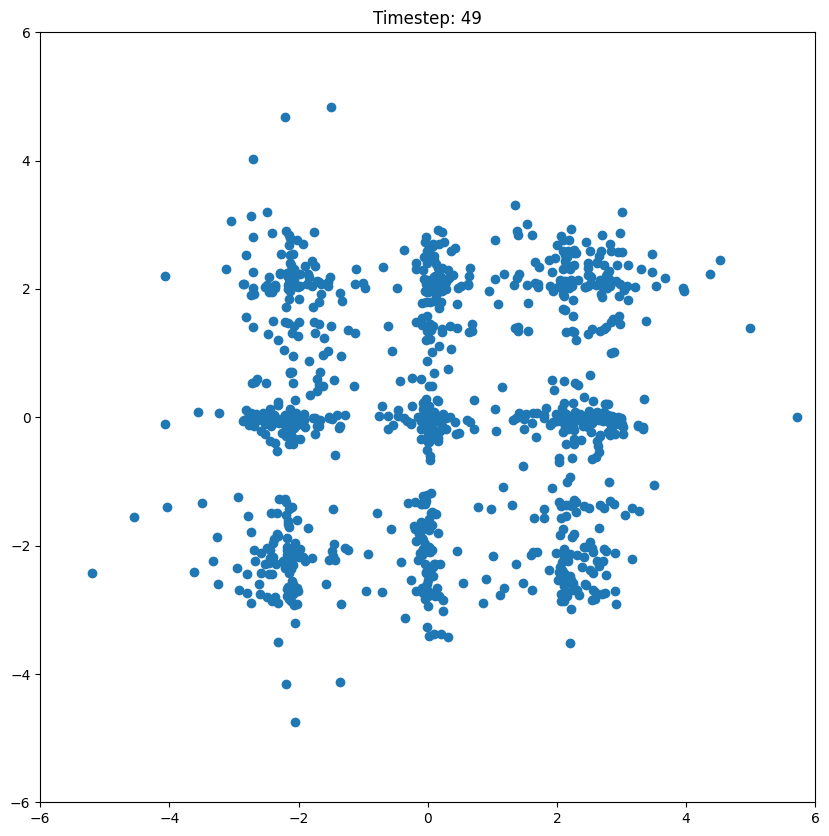

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

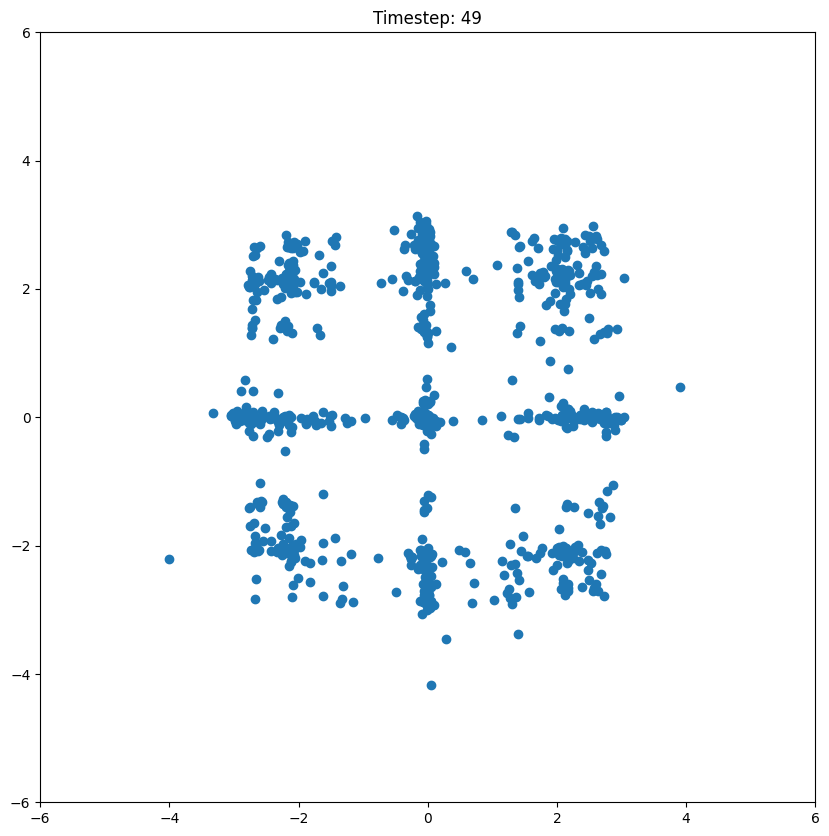

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

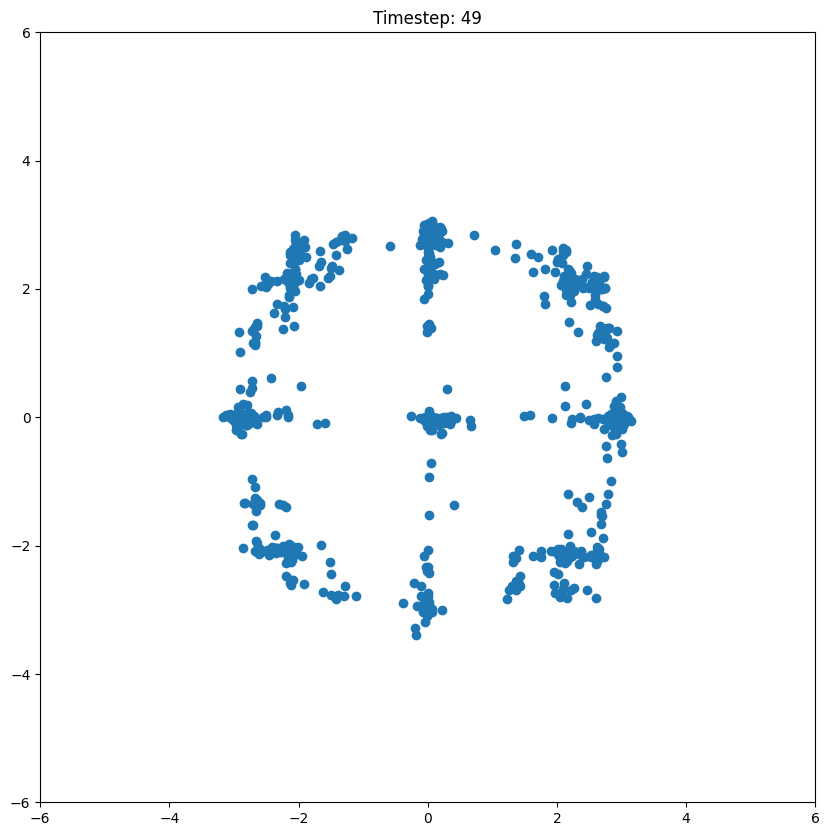

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

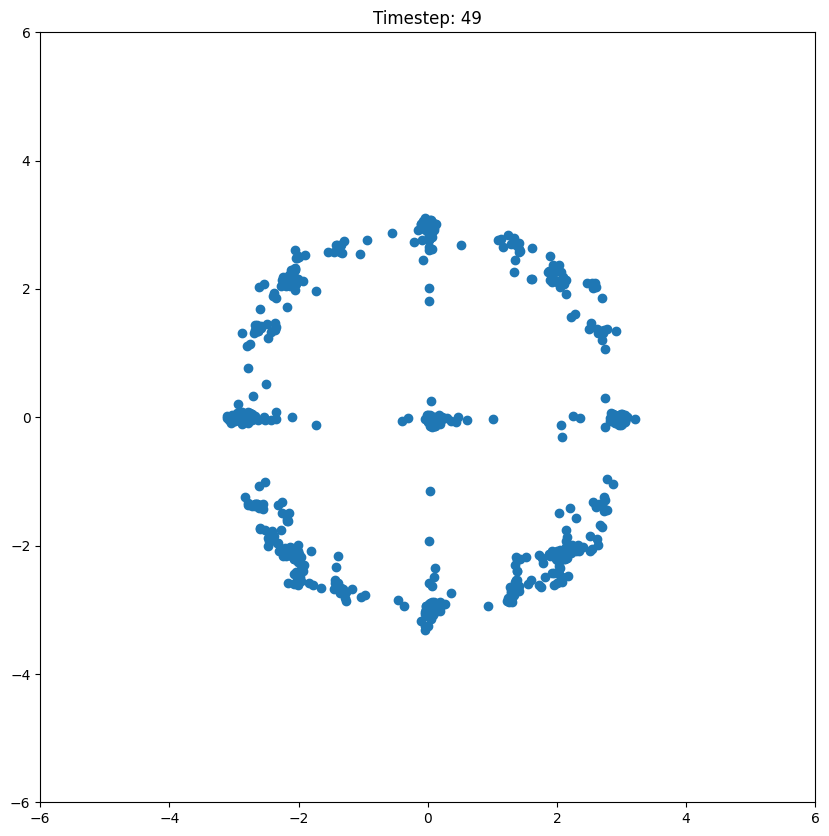

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

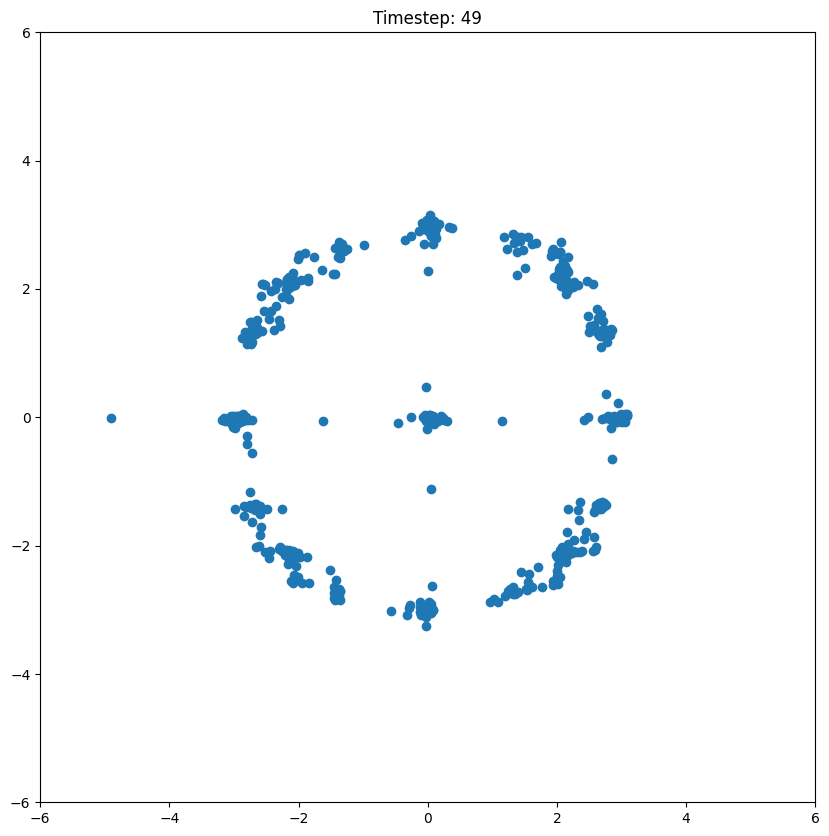

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

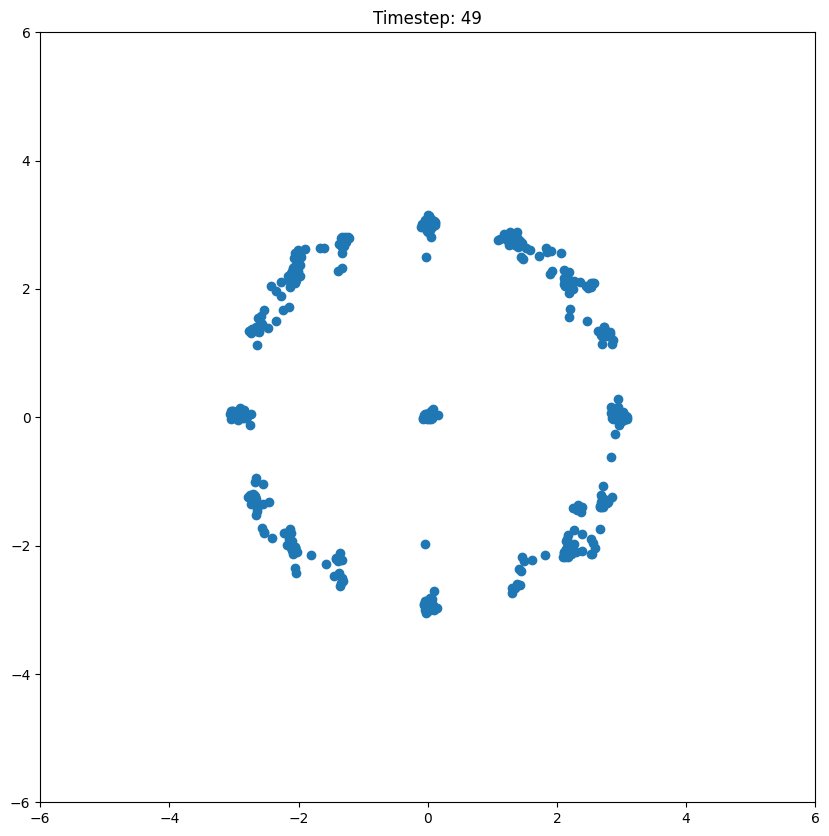

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

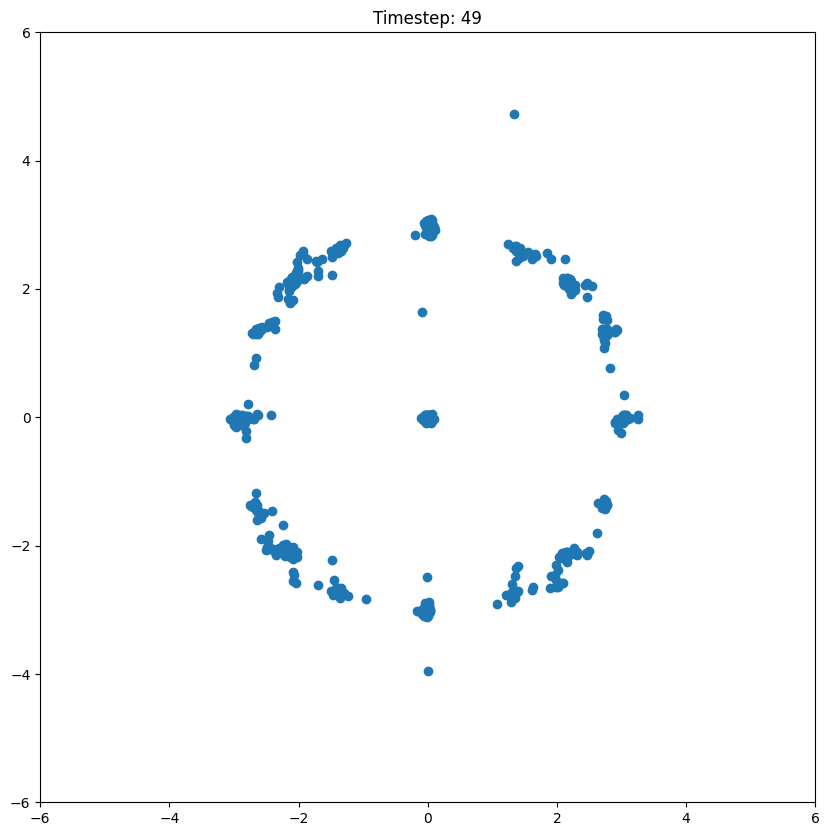

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

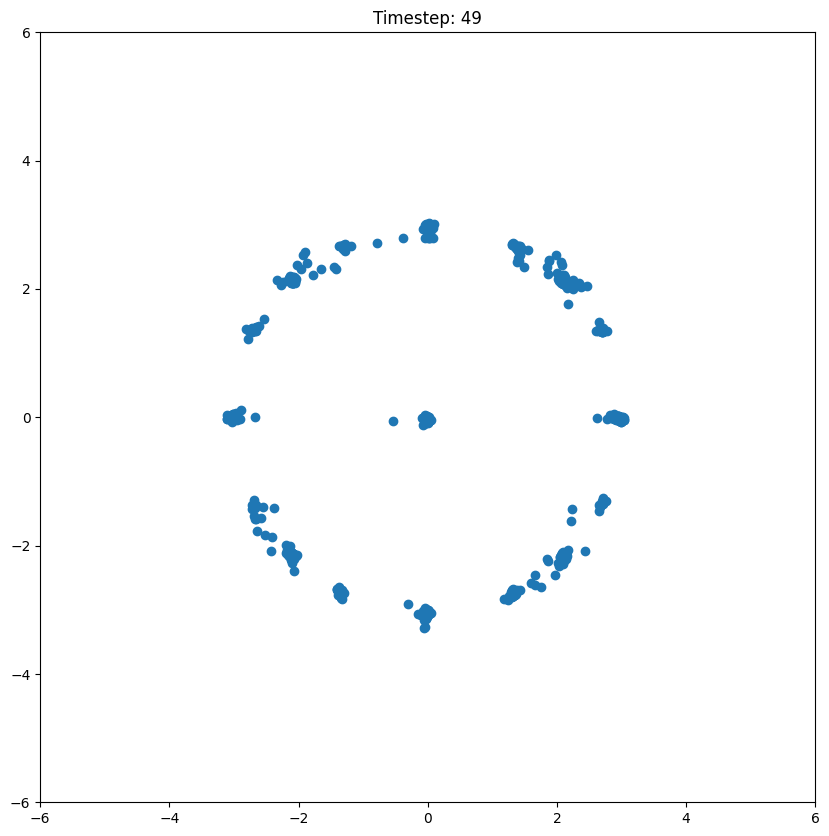

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

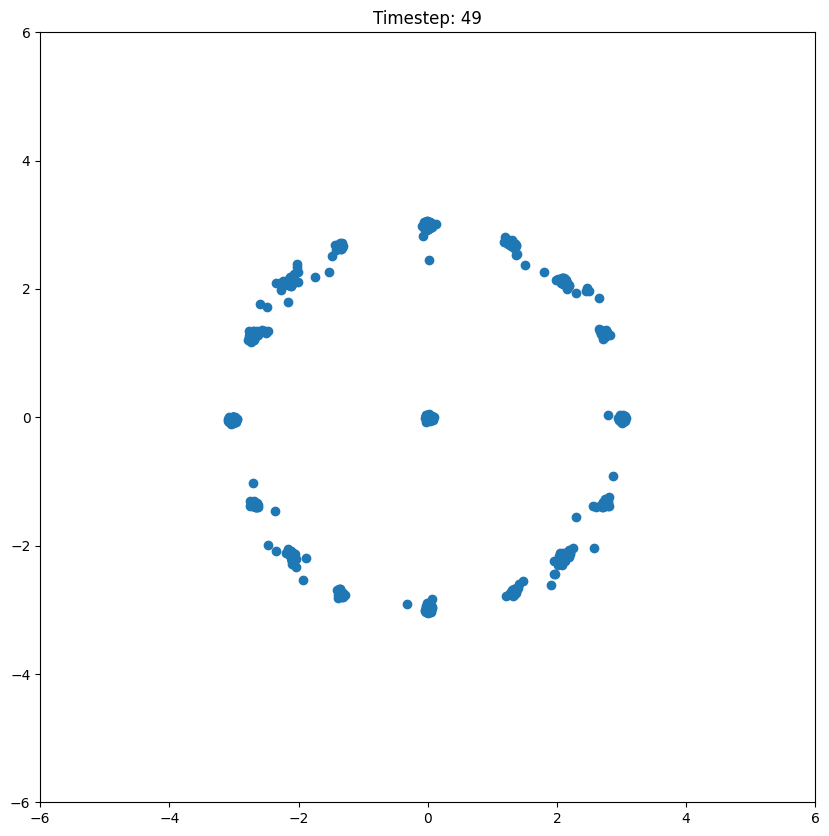

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

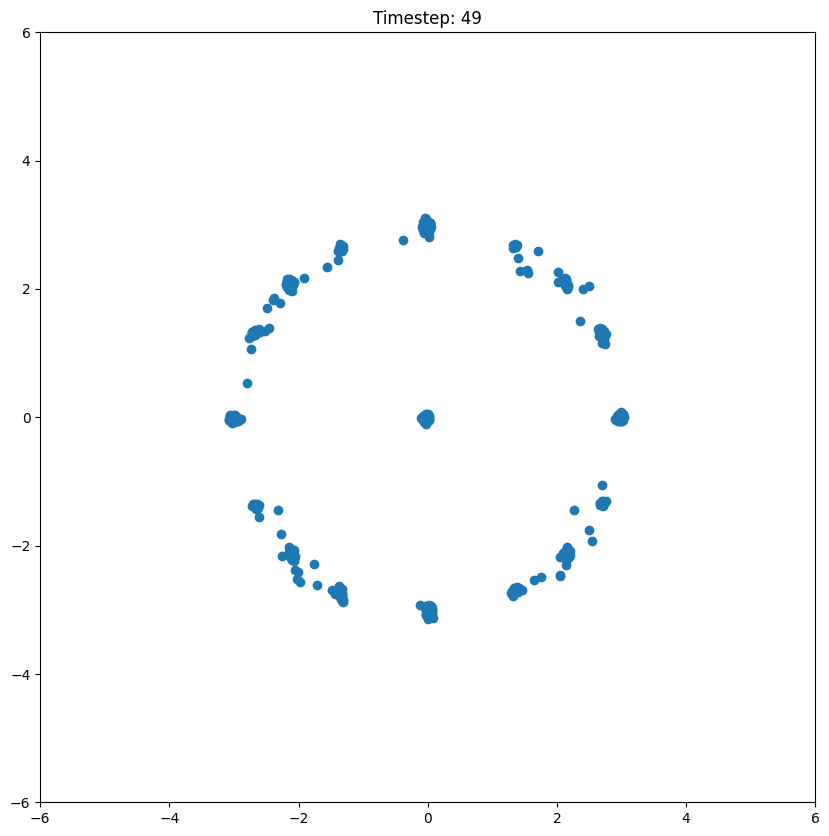

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

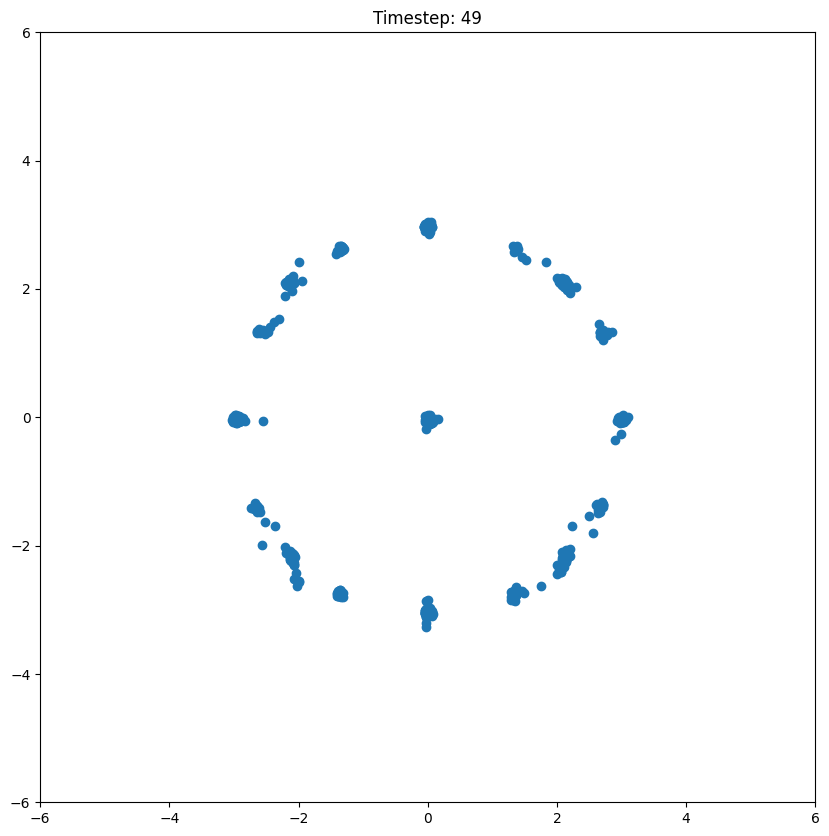

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

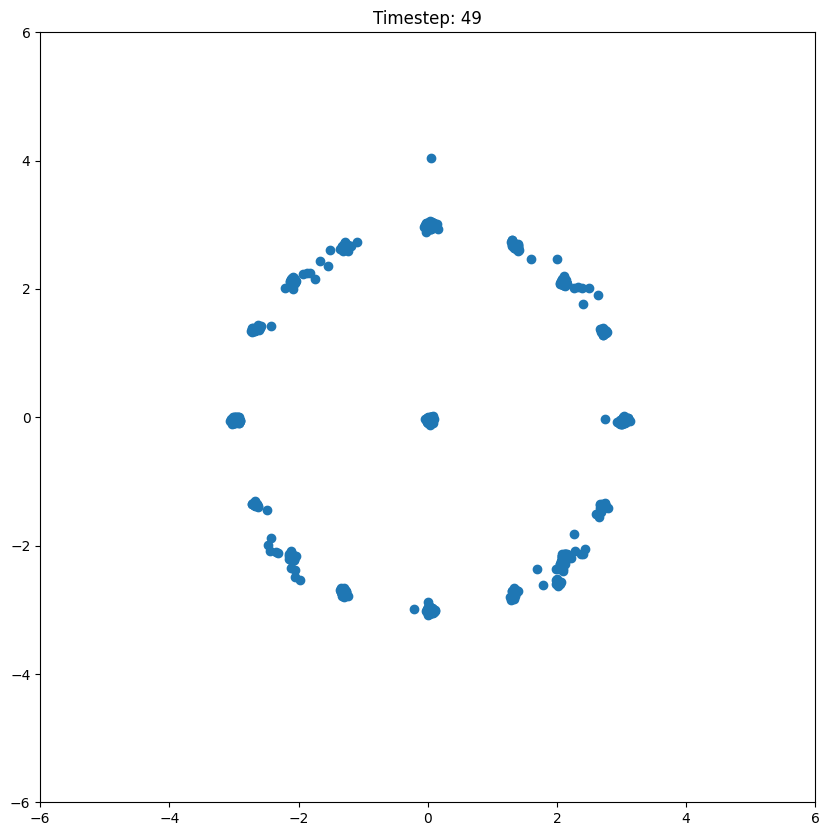

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

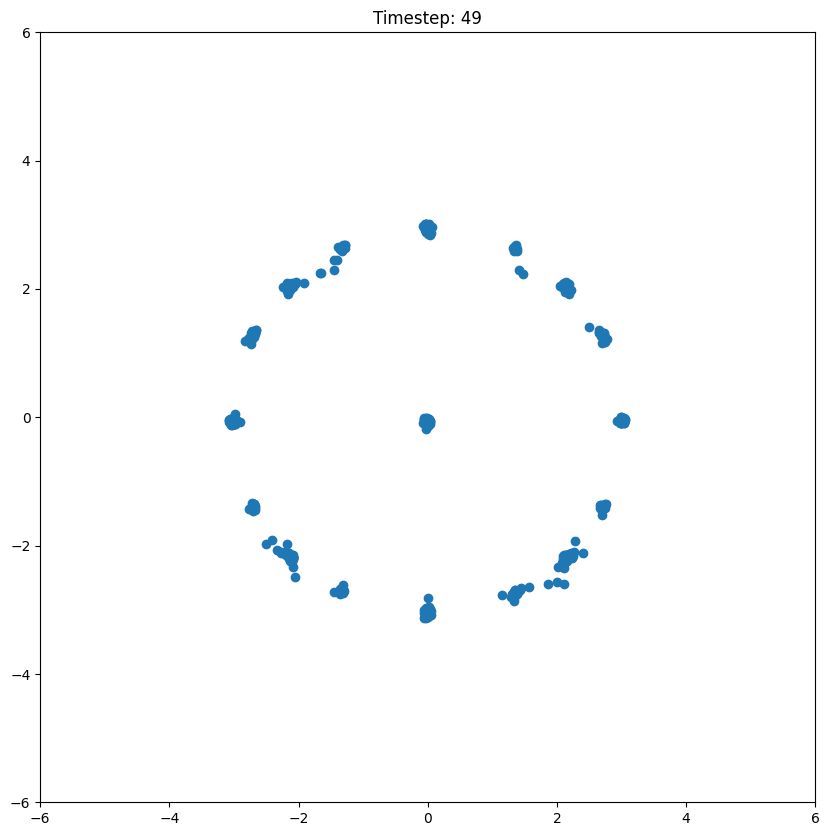

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

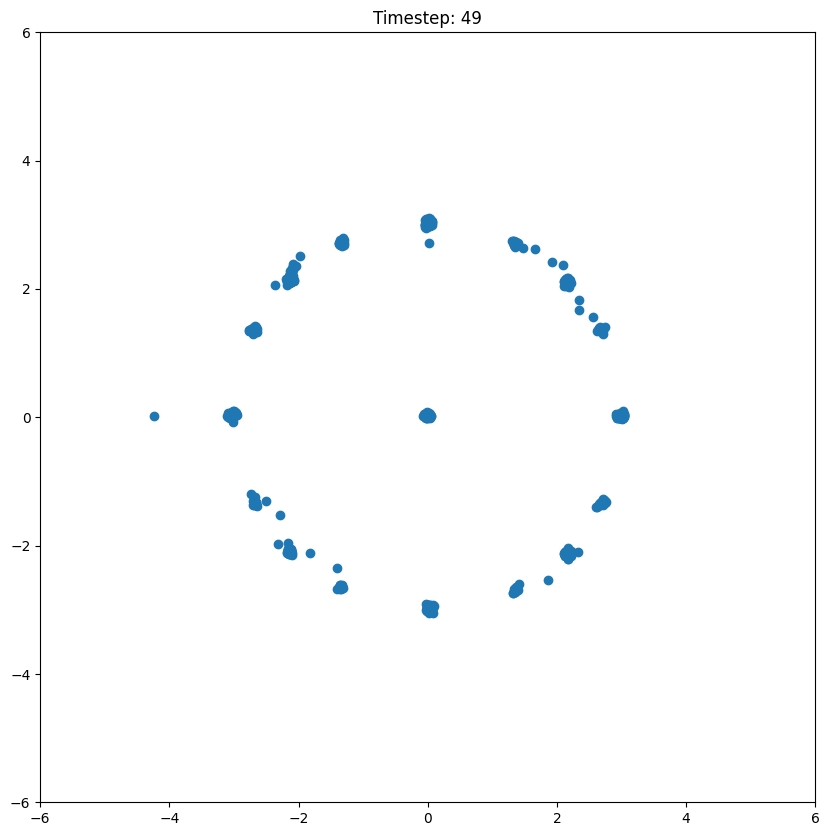

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

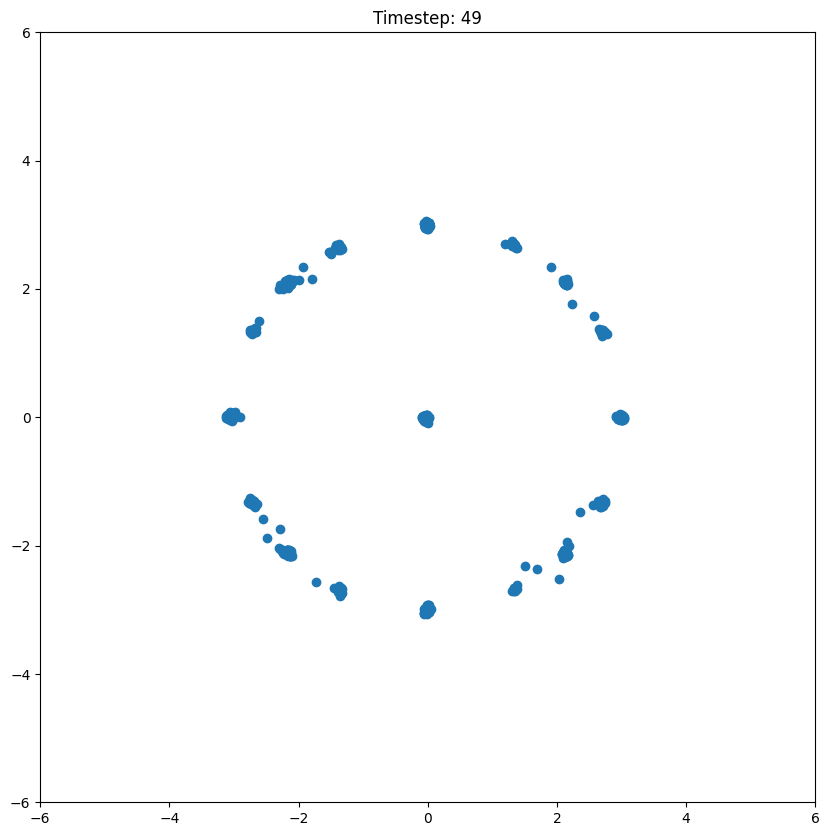

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

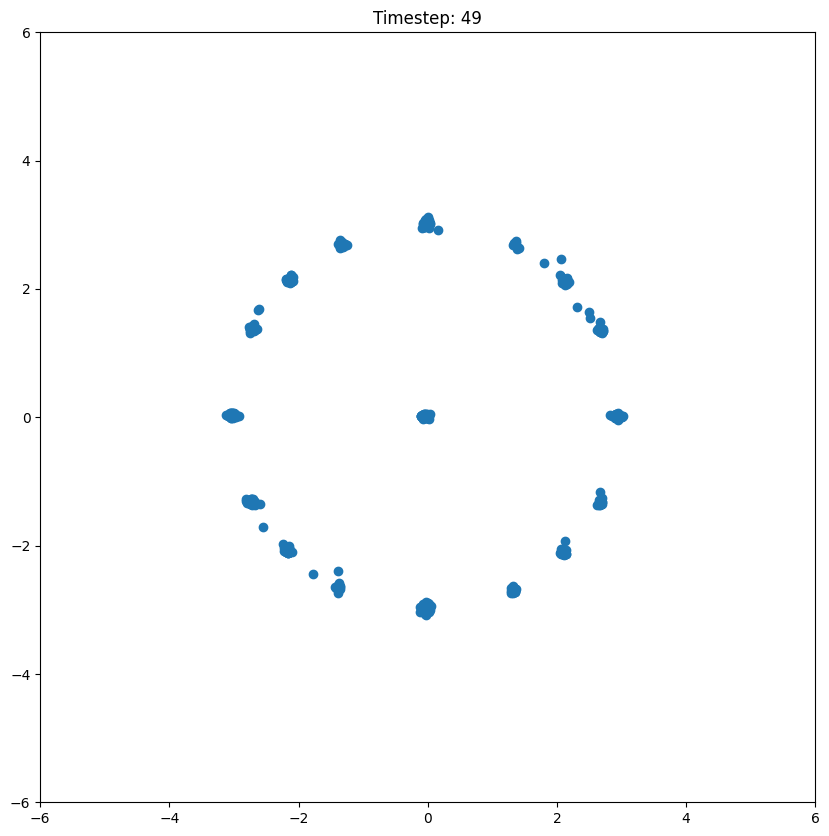

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

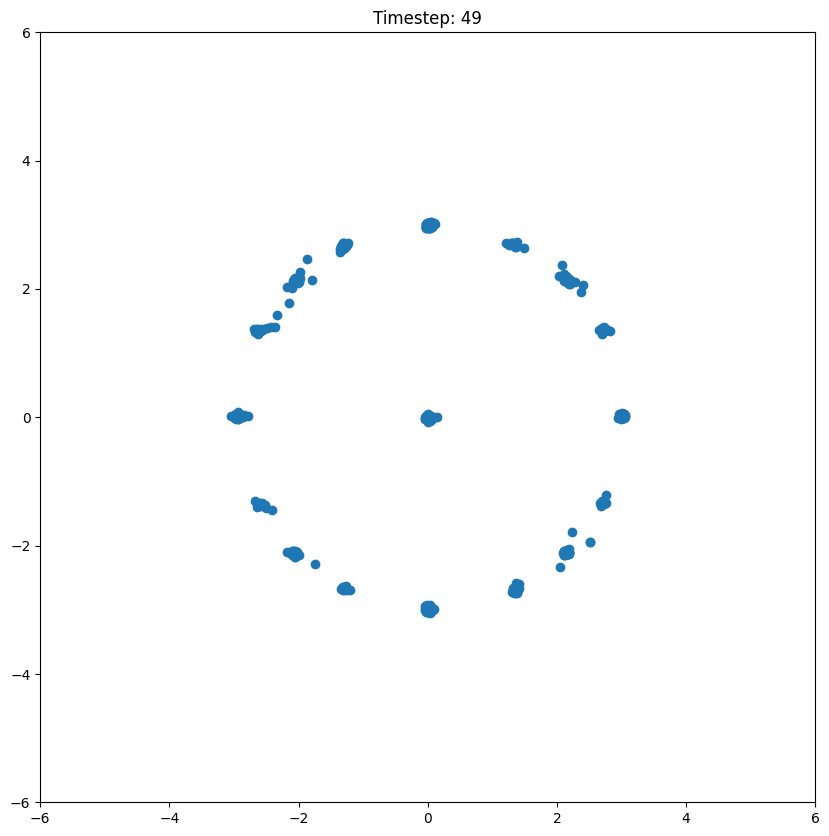

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

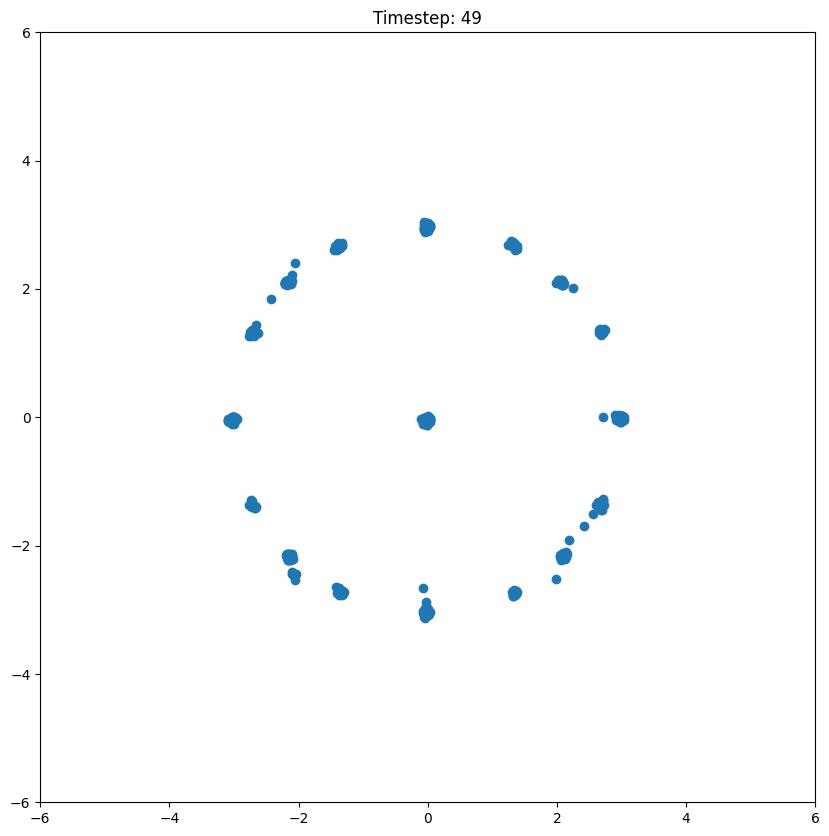

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

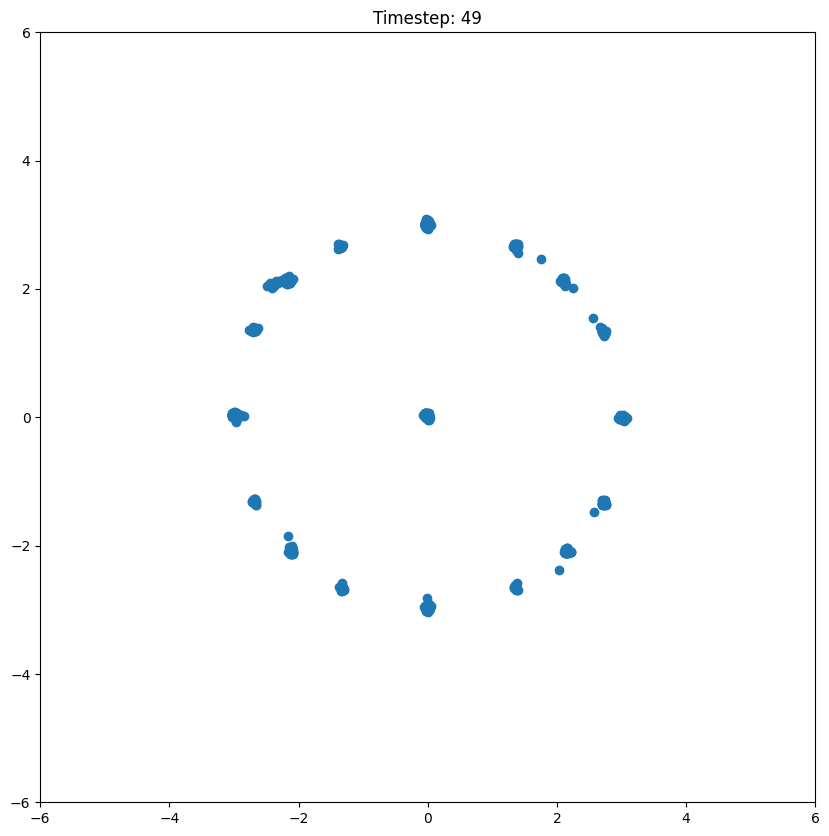

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

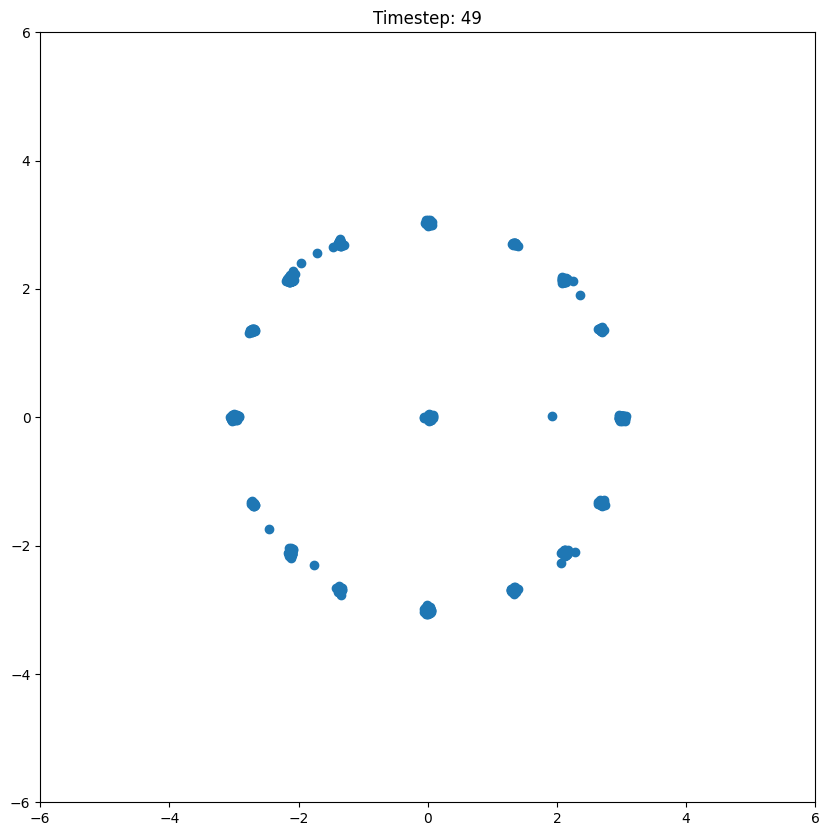

Saving model...
Saving images...


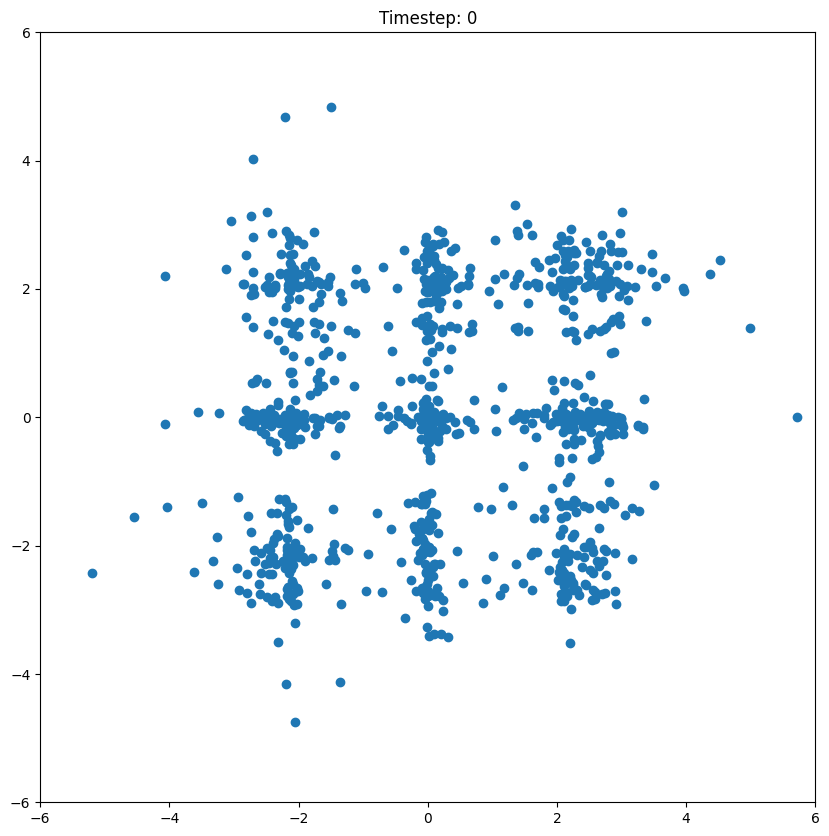

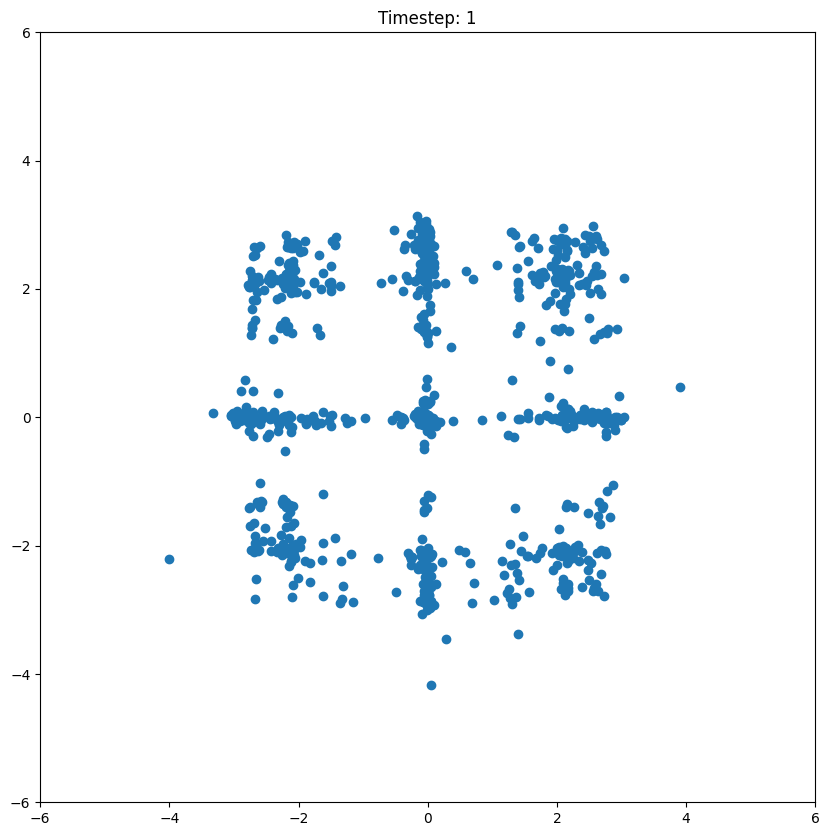

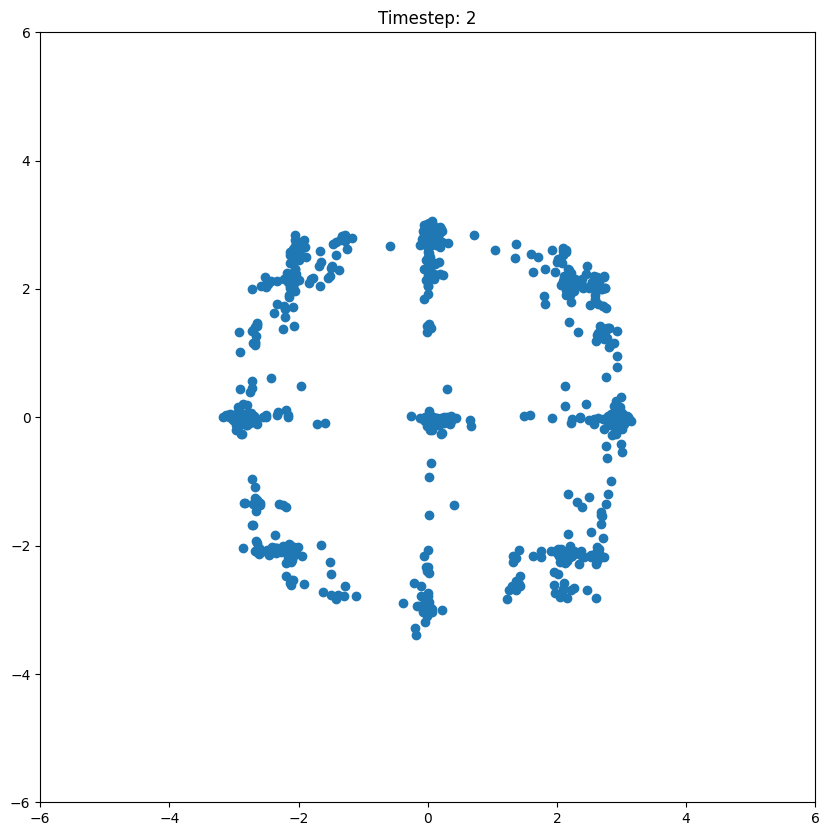

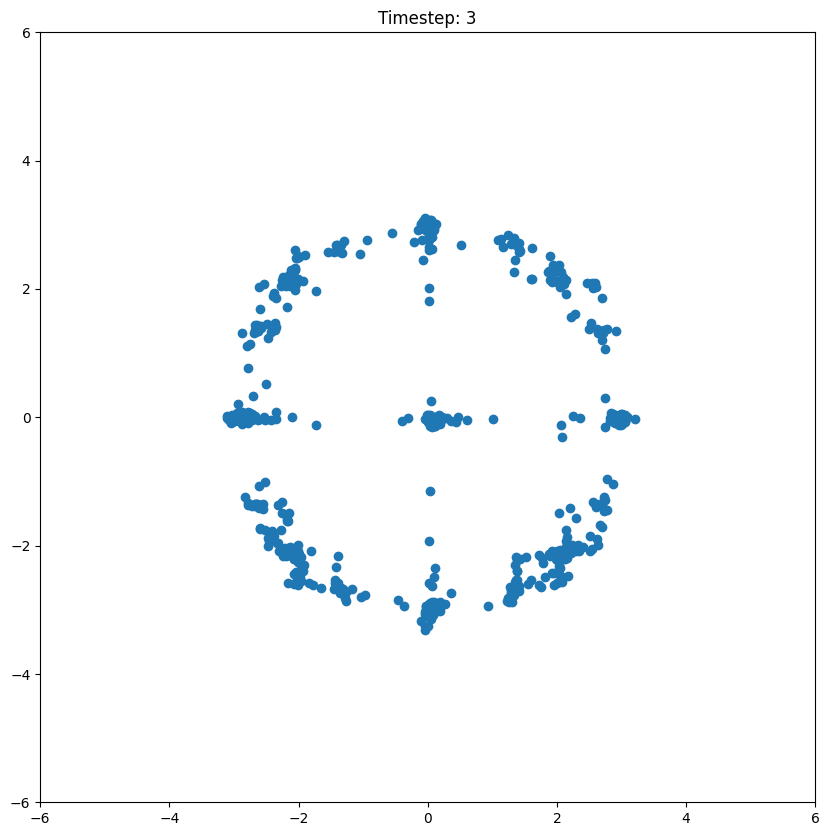

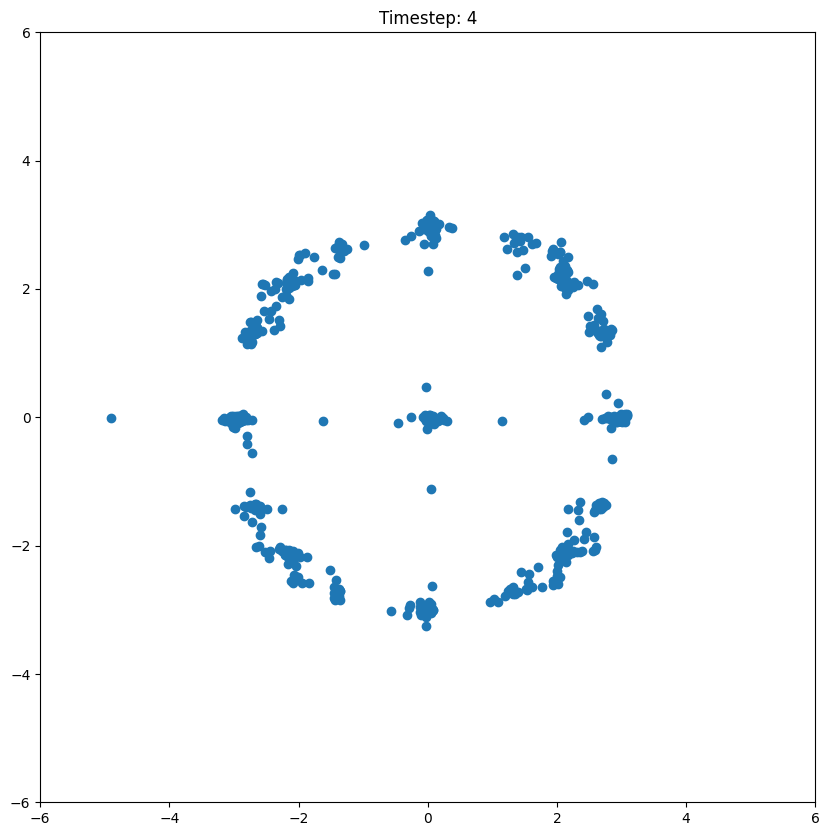

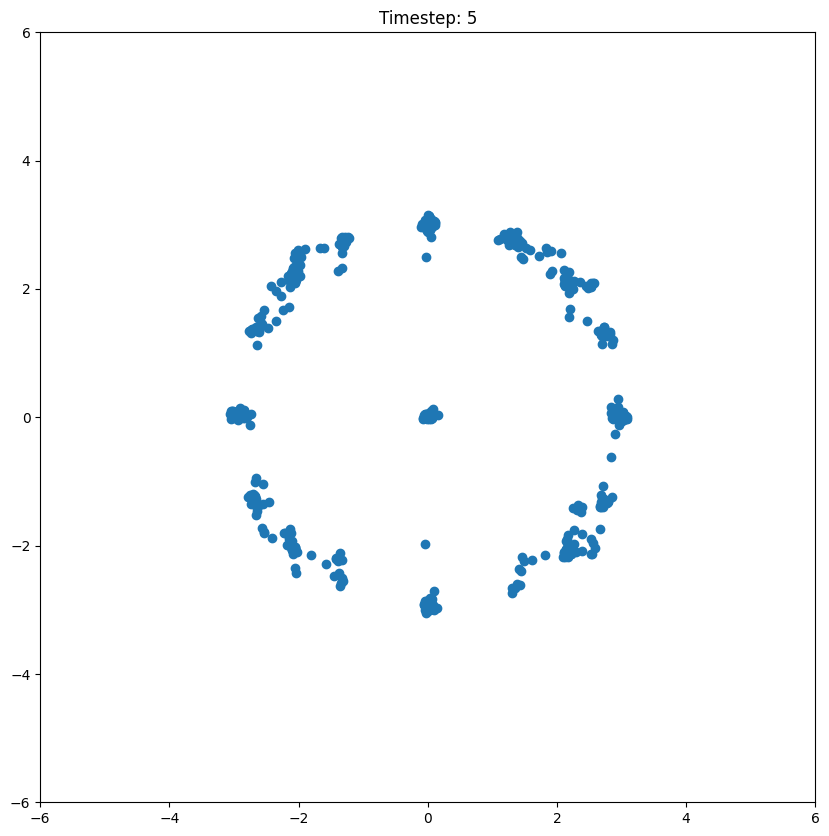

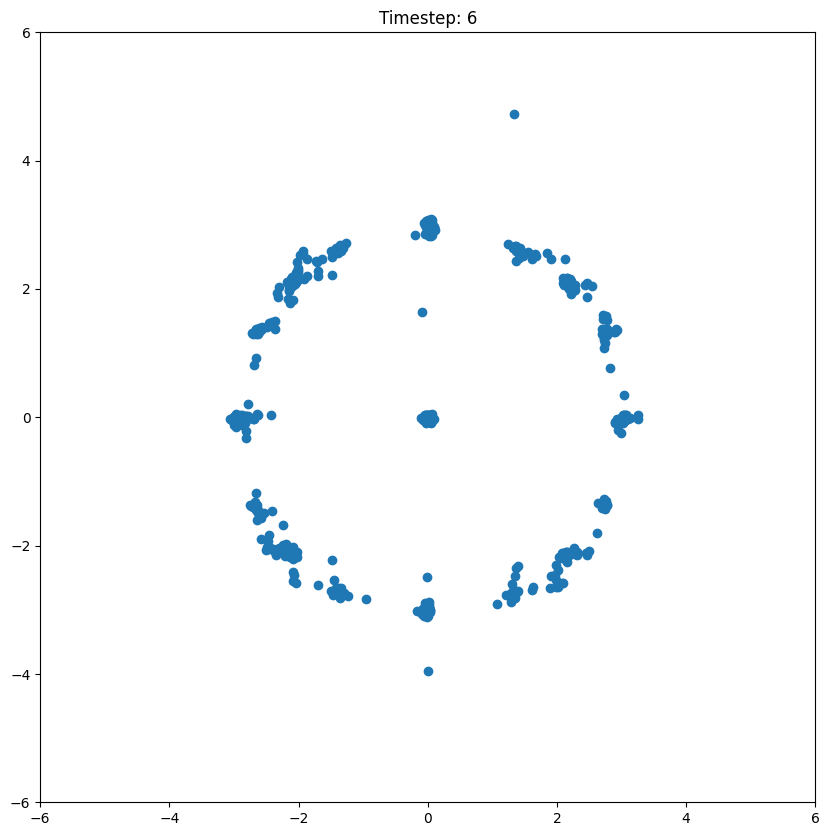

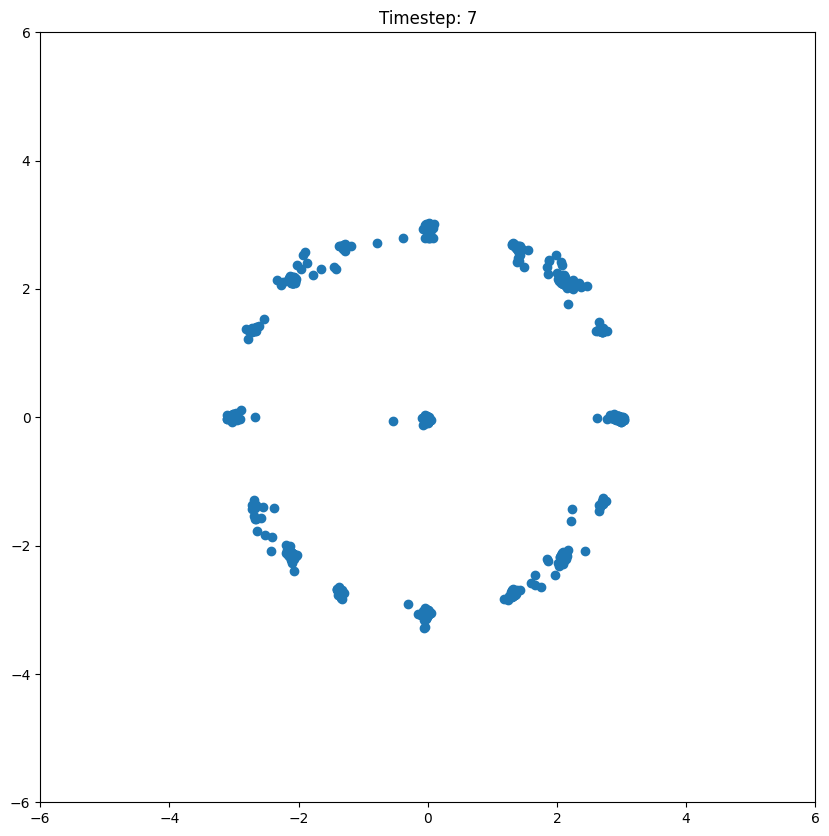

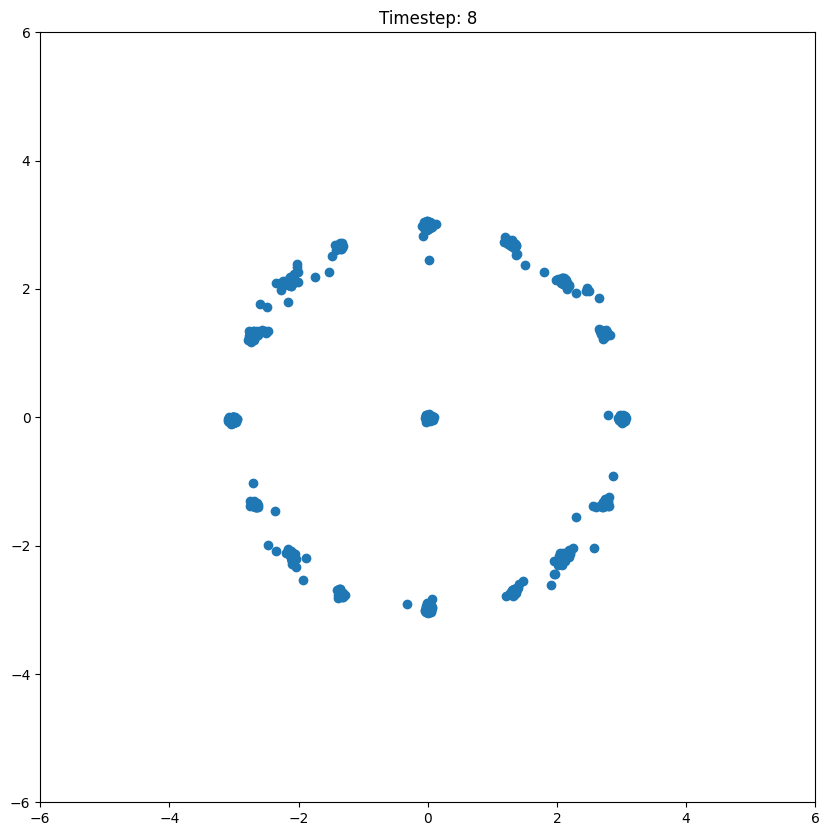

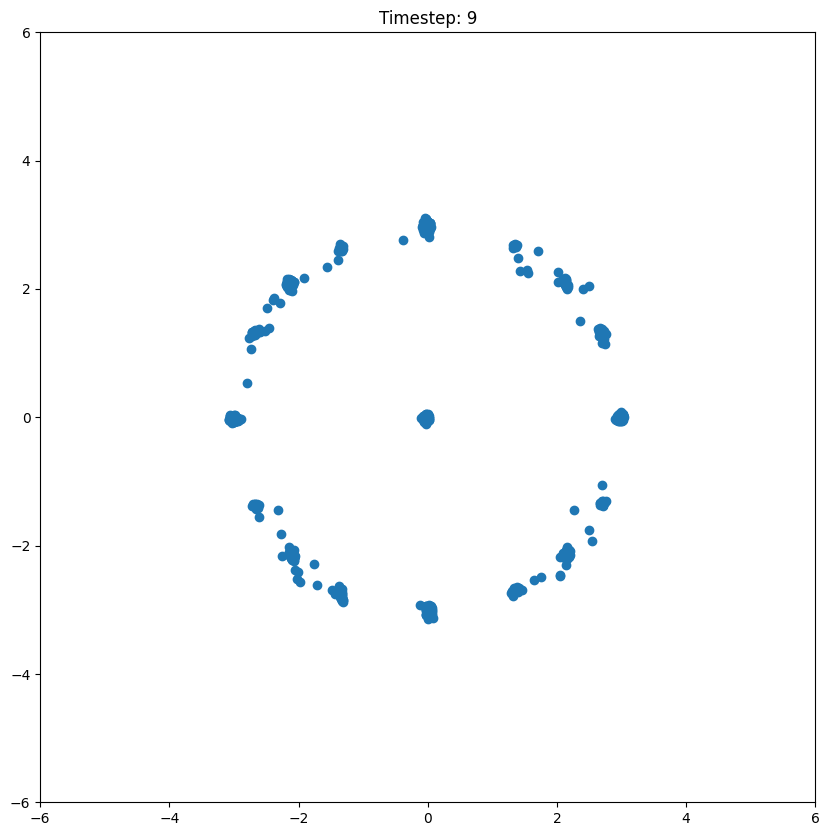

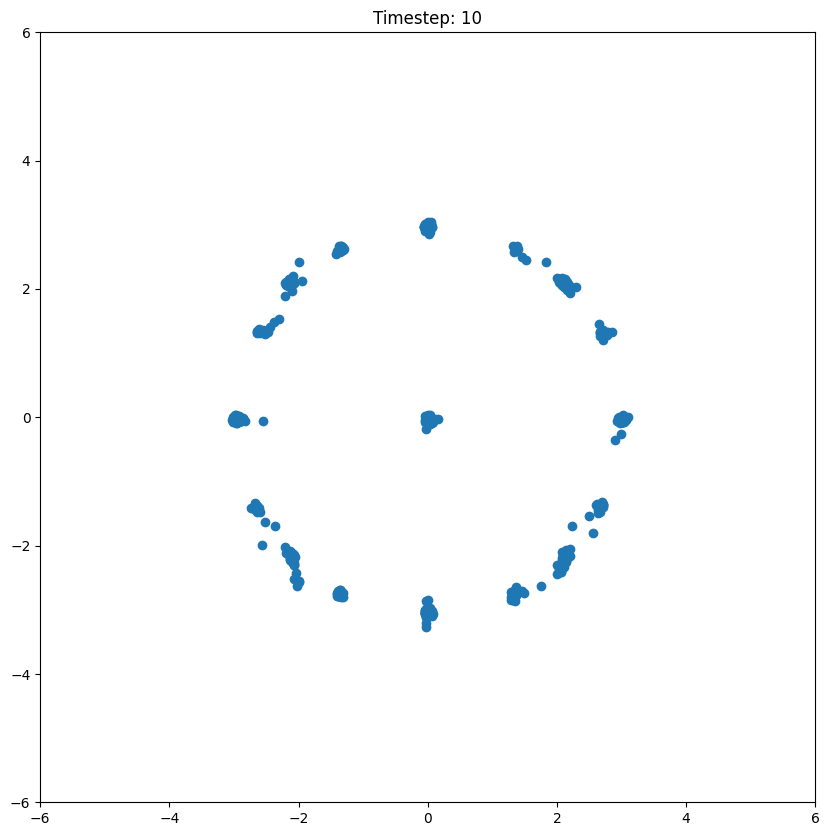

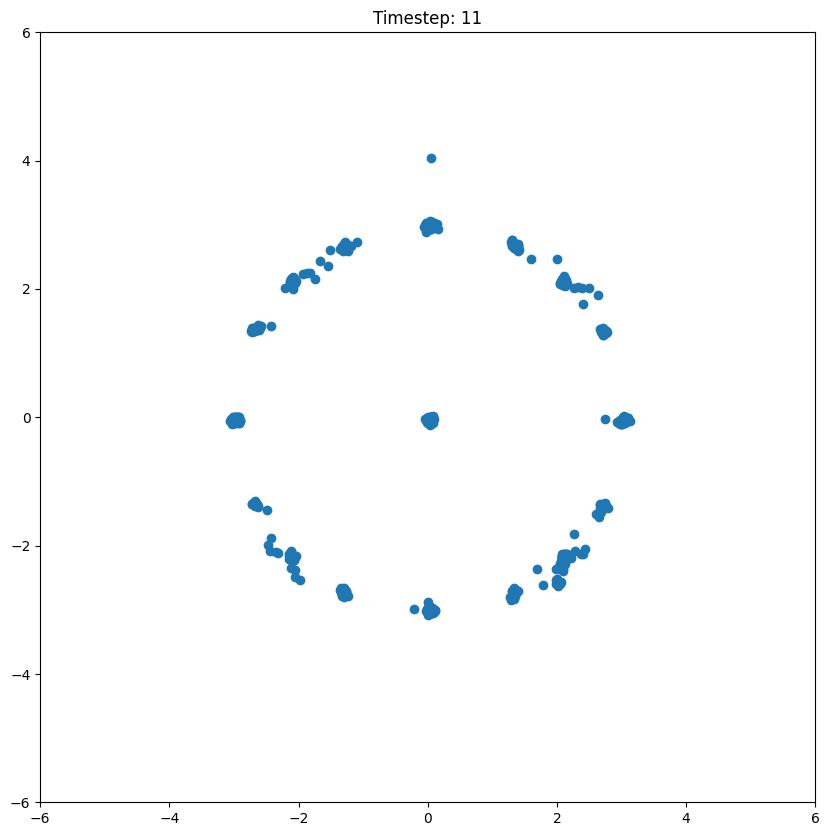

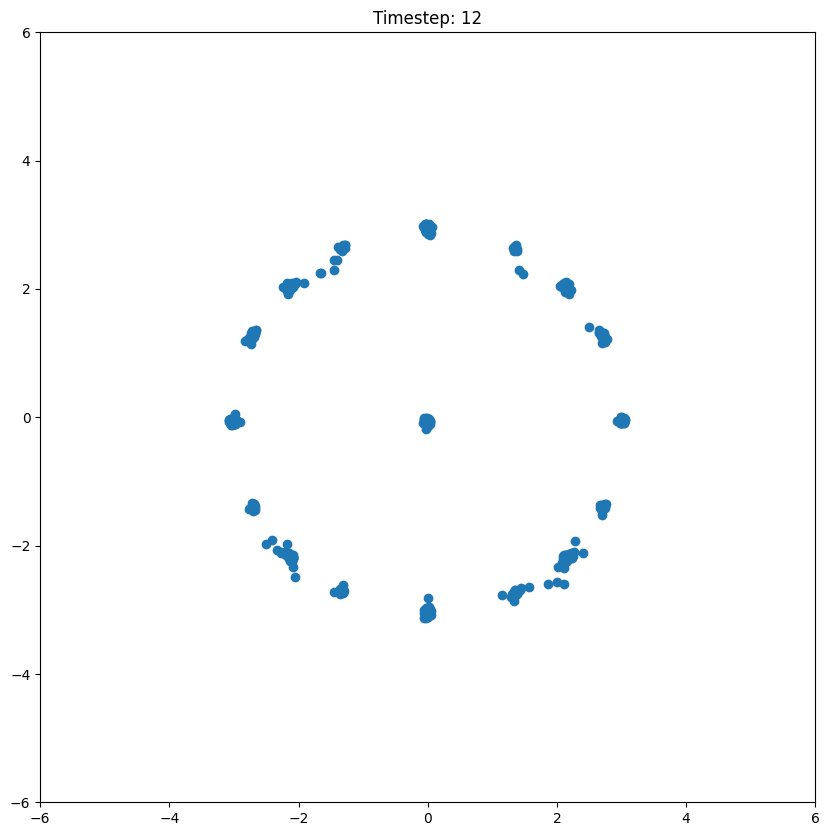

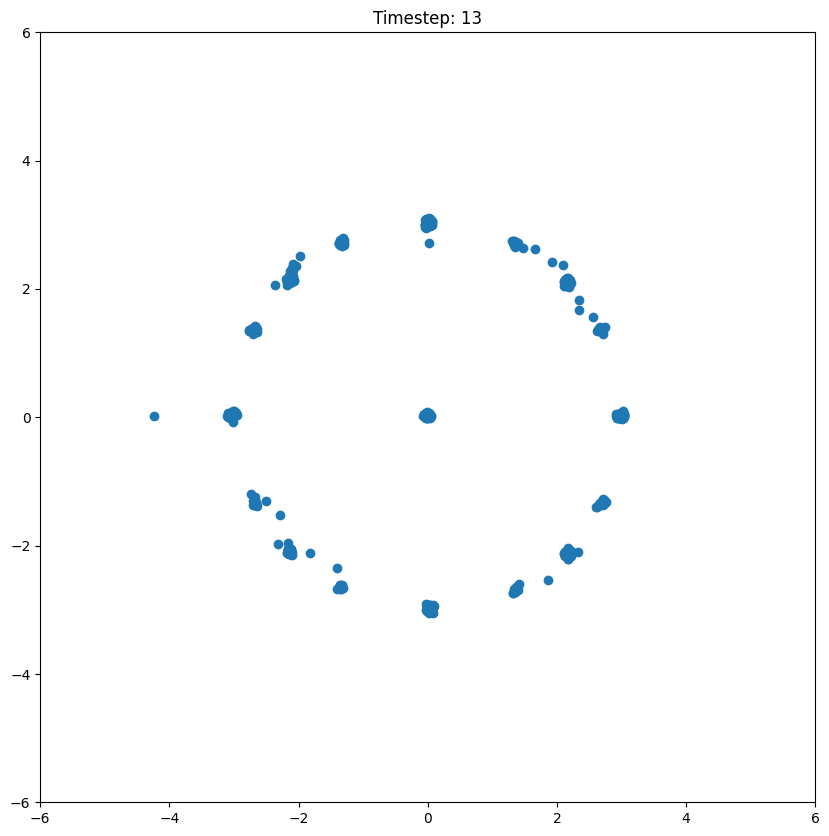

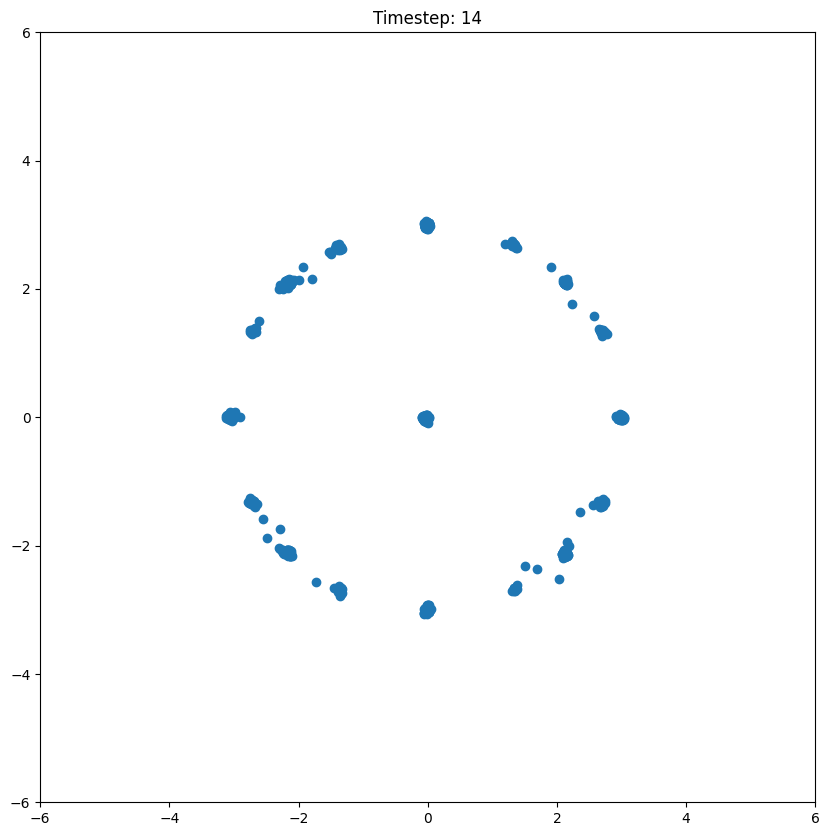

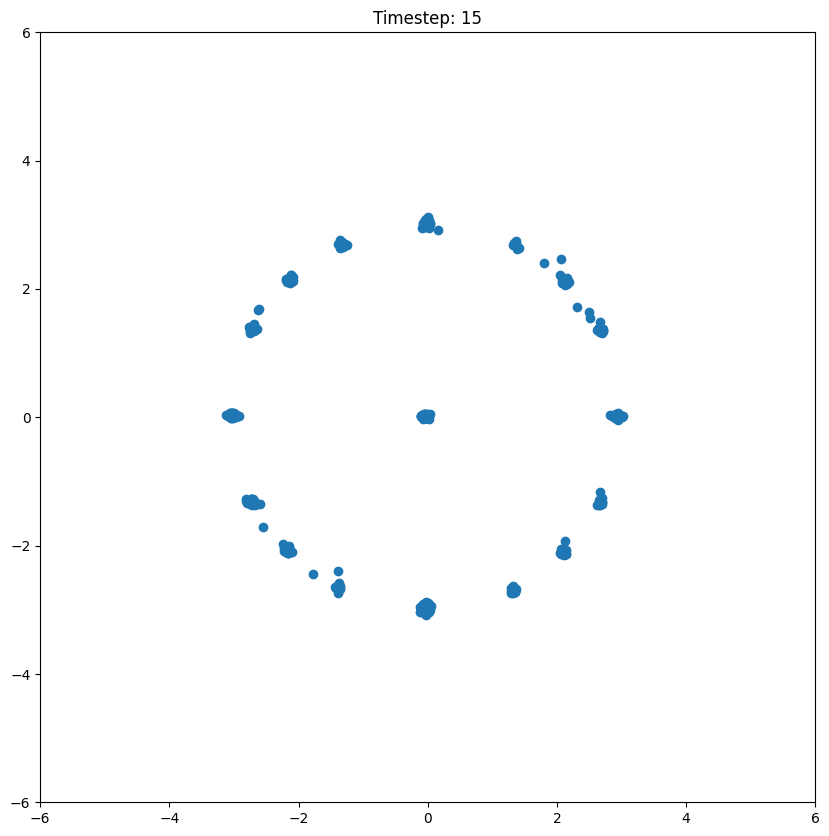

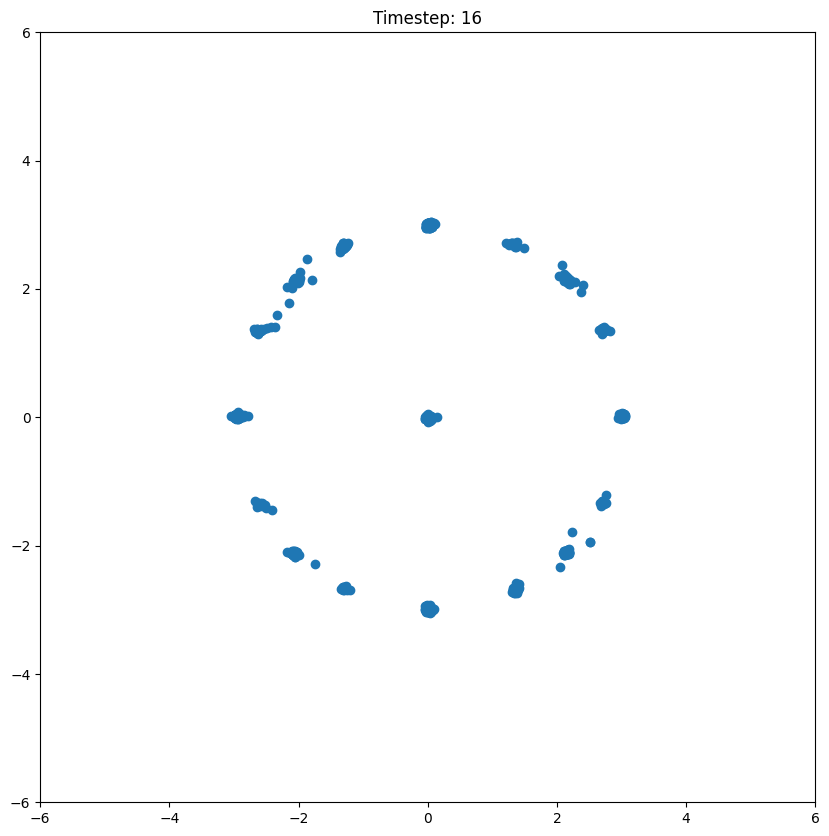

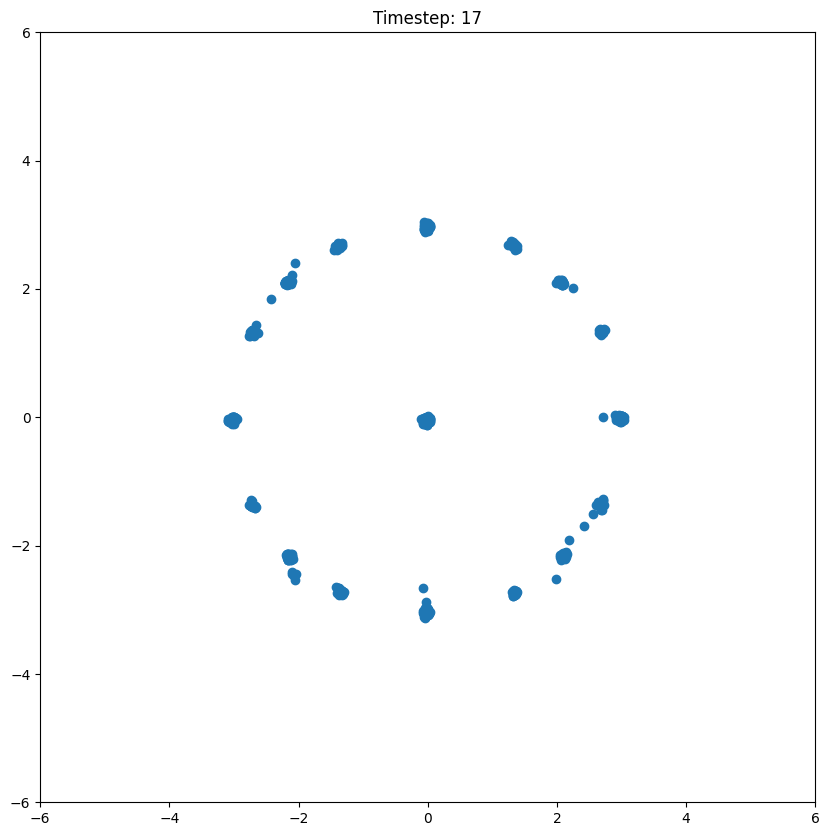

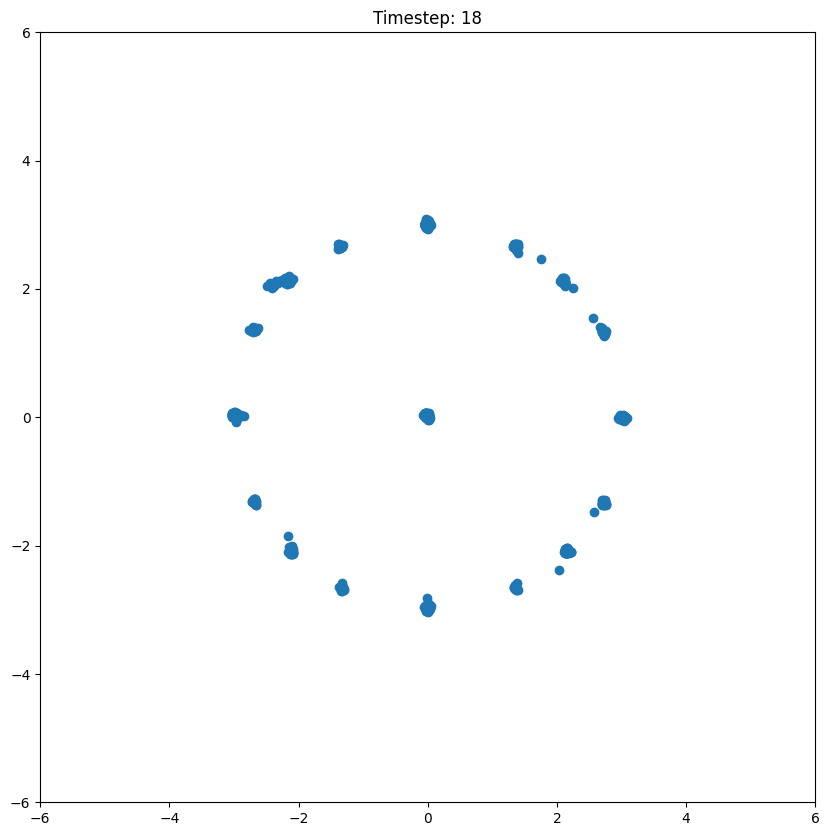

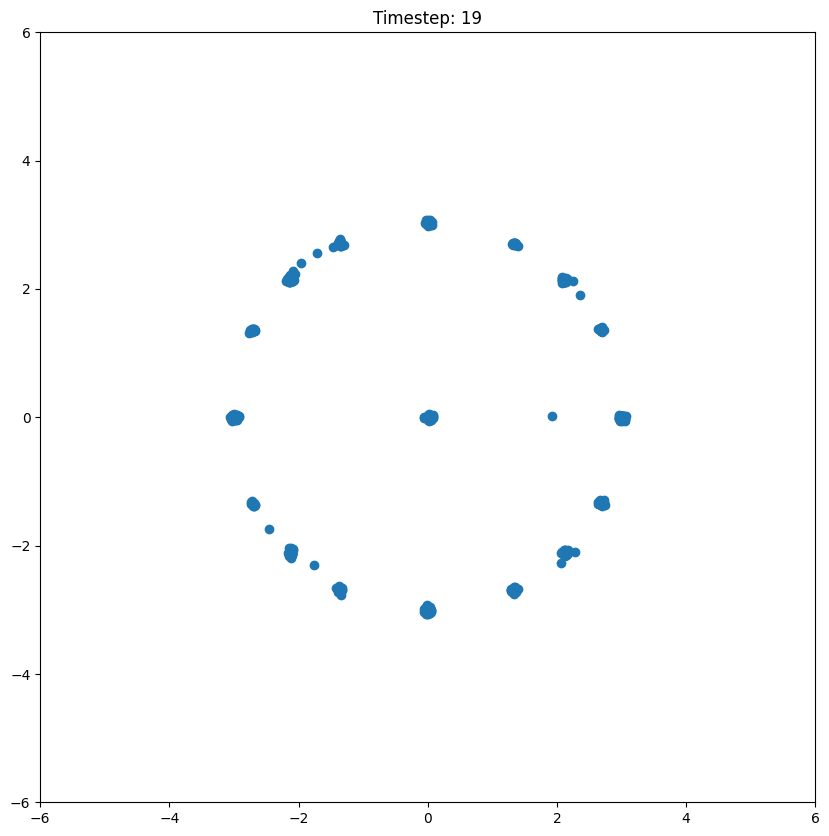

Saving loss as numpy array...
Saving frames...


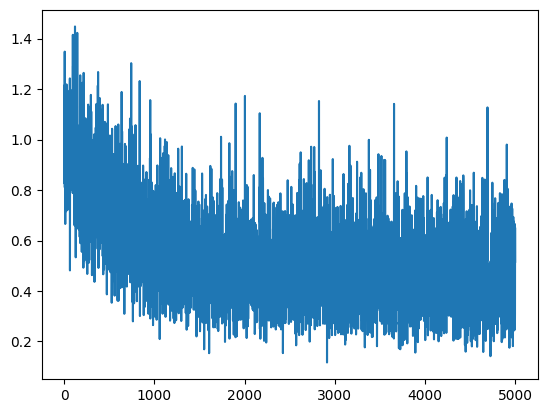

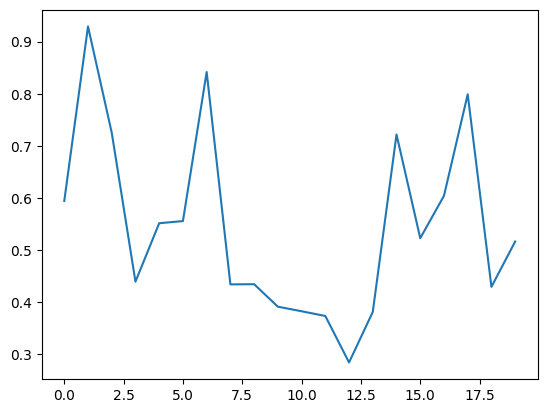

In [ ]:
dataset = get_dataset(config.dataset)
dataloader = DataLoader(
    dataset, batch_size=config.train_batch_size, shuffle=True, drop_last=True)

model = MLP(
    hidden_size=config.hidden_size,
    hidden_layers=config.hidden_layers,
    emb_size=config.embedding_size,
    time_emb=config.time_embedding,
    input_emb=config.input_embedding).to(device)

noise_scheduler = NoiseScheduler(
    num_timesteps=config.num_timesteps,
    beta_schedule=config.beta_schedule).to(device)

optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=config.learning_rate,


)

xmin, xmax = -6, 6
ymin, ymax = -6, 6

global_step = 0
frames = []
losses = []
epoch_losses_outer = []
print("Training model...")

for epoch in range(config.num_epochs):
    model.train()
    progress_bar = tqdm(total=len(dataloader))
    progress_bar.set_description(f"Epoch {epoch}")
    epoch_losses = []
    for step, batch in enumerate(dataloader):

        batch = batch[0]
        noise = torch.randn(batch.shape)
        # pdb.set_trace()

        # # ################model predicts noise###################
        timesteps = torch.randint(
             0, noise_scheduler.num_timesteps, (batch.shape[0],)
         ).long()

        batch = batch.to(device)
        noise = noise.to(device)
        timesteps = timesteps.to(device)

        # pdb.set_trace()

        noisy = noise_scheduler.add_noise(batch, noise, timesteps) #steps in between true batch and pure isotropic gaussian noise
        noise_pred = model(noisy, timesteps) #guess noise for each of these noisy images
        # pdb.set_trace()


        loss = F.mse_loss(noise_pred, noise)
        loss.backward(loss)

        # # #######################################################

        # ################model predicts noisy image itself#######

        # timesteps = torch.randint(
        #     1, noise_scheduler.num_timesteps, (batch.shape[0],)
        # ).long()

        # batch = batch.to(device)
        # noise = noise.to(device)
        # timesteps = timesteps.to(device)
        # prev_timesteps = timesteps - 1

        # # pdb.set_trace()

        # noisy = noise_scheduler.add_noise(batch, noise, timesteps) #steps in between true batch and pure isotropic gaussian noise
        # noisy_prev = noise_scheduler.add_noise(batch, noise, prev_timesteps)


        # # pdb.set_trace()

        # x_prev_pred = model(noisy, timesteps) #guess prev x for each of these noisy images
        # noise_pred = noise_scheduler.x_to_noise(x_prev_pred,noise,prev_timesteps)
        # loss1 = F.mse_loss(x_prev_pred, noisy_prev)

        # # z_curr = model.encode(noisy,timesteps)
        # # z_prev = model.encode(noisy_prev,prev_timesteps)
        # # loss2 = F.mse_loss(model.linear_system(z_curr),z_prev)

        # # loss = F.l1_loss(x_prev_pred, noisy_prev)
        # # loss = F.mse_loss(noise_pred, noise)
        # # loss = loss1 + loss2

        # loss = loss1

        # loss.backward(loss)

        # ###########################################################

        # nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        optimizer.zero_grad()

        progress_bar.update(1)
        logs = {"loss": loss.detach().item(), "step": global_step}
        losses.append(loss.detach().item())
        # epoch_losses.append(loss.detach().item())
        progress_bar.set_postfix(**logs)
        global_step += 1

    progress_bar.close()
    epoch_losses_outer.append(loss.detach().item())
    if epoch % config.save_images_step == 0 or epoch == config.num_epochs - 1:
        # generate data with the model to later visualize the learning process
        model.eval()
        sample = torch.randn(config.eval_batch_size, 2).to(device)
        timesteps = list(range(len(noise_scheduler)))[::-1]
        for i, t in enumerate(tqdm(timesteps)):
            t = torch.from_numpy(np.repeat(t, config.eval_batch_size)).long().to(device)
            with torch.no_grad():
                residual = model(sample, t) #guess noise amount from pure noise
            sample = noise_scheduler.step(residual, t[0], sample) #(This is g. The problem is that this takes in noise as well)
            sample = g_wrapper(model,sample,t)
            # with torch.no_grad():
            #     sample = model(sample,t)        ##prediction of prev x directly

        frame = sample.detach().cpu().numpy()
        frames.append(frame)

        plt.figure(figsize=(10, 10))
        plt.scatter(frame[:, 0], frame[:, 1])
        plt.xlim(xmin, xmax)
        plt.ylim(ymin, ymax)
        plt.title(f"Timestep: {i}")
        plt.show()
        plt.close()





print("Saving model...")
outdir = f"exps/{config.experiment_name}"
os.makedirs(outdir, exist_ok=True)
torch.save(model.state_dict(), f"{outdir}/model.pth")

print("Saving images...")
imgdir = f"{outdir}/images"
os.makedirs(imgdir, exist_ok=True)
frames = np.stack(frames)
xmin, xmax = -6, 6
ymin, ymax = -6, 6

for i, frame in enumerate(frames):
    plt.figure(figsize=(10, 10))
    plt.scatter(frame[:, 0], frame[:, 1])
    plt.xlim(xmin, xmax)
    plt.ylim(ymin, ymax)
    plt.title(f"Timestep: {i}")
    plt.savefig(f"{imgdir}/{i:04}.png")
    plt.show()
    plt.close()

print("Saving loss as numpy array...")
np.save(f"{outdir}/loss.npy", np.array(losses))

print("Saving frames...")
np.save(f"{outdir}/frames.npy", frames)


plt.plot(losses)
plt.show()

plt.plot(epoch_losses_outer)
plt.show()

In [ ]:
# Save entire model
torch.save(model, 'model_1_loss.pth')


#Demo

In [ ]:
model = torch.load('model_2_loss.pth')

In [ ]:
num_timesteps = 50
noise_scheduler = NoiseScheduler(num_timesteps=num_timesteps)
noise_scheduler.to(device)

dataset = get_dataset("circle", n=1000)
x0 = dataset.tensors[0]

x0 = x0.to(device)

In [ ]:
forward_samples = []
forward_samples.append(x0.cpu().numpy())
for t in range(len(noise_scheduler)):
    timesteps = np.repeat(t, len(x0))
    noise = torch.randn_like(x0)
    sample = noise_scheduler.add_noise(x0, noise, timesteps)
    forward_samples.append(sample.cpu().numpy())

In [ ]:
eval_batch_size = len(dataset)
sample = torch.randn(eval_batch_size, 2).to(device)
timesteps = list(range(num_timesteps))[::-1]
reverse_samples = []
reverse_samples.append(sample.cpu().numpy())

for i, t in enumerate(tqdm(timesteps)):
    t = torch.from_numpy(np.repeat(t, eval_batch_size)).long().to(device)
    with torch.no_grad():
        residual = model(sample, t)
        # pdb.set_trace()
    sample = noise_scheduler.step(residual, t[0], sample) #standard diffusion
    # sample = residual #input space diffusion


    reverse_samples.append(sample.cpu().numpy())

  0%|          | 0/50 [00:00<?, ?it/s]

In [ ]:
def get_spaced_indices(lst, n):
    if n <= 1:
        return [0]  # Only the first element if n is less than or equal to 1
    length = len(lst)
    indices = set()  # Use a set to avoid duplicates
    step = (length - 1) / (n - 1)  # Compute the step as a floating point to avoid rounding too soon

    for i in range(n):
        idx = int(round(i * step))  # Calculate index at each step and round it to the nearest integer
        if idx < length:  # Ensure index is within bounds
            indices.add(idx)

    # Ensure the last index is included
    indices.add(length - 1)

    # Convert to sorted list and ensure we only take n elements
    sorted_indices = sorted(indices)[:n]
    return sorted_indices




def plot_samples(samples,num_subplots = 6,reverse = False,indices = None,max_index = 50,title = None):
    # pdb.set_trace()

    fig, axes = plt.subplots(1, num_subplots, figsize=(3 * num_subplots, 3))

    if indices is None:
      indices = list(range(0,len(samples)))


    if num_subplots == len(samples):
      stepsize = 1
    else:
      stepsize = int(len(indices)/(num_subplots-1))

    new_indices = get_spaced_indices(indices,num_subplots)



      # se?lected_samples = [forward_samples[i] for i in indices]
    # pdb.set_trace()
    for ax, sample_ind in zip(axes.flatten(), new_indices):
        sample = samples[sample_ind]

        ind = indices[sample_ind]
        if reverse:
          ind = max_index - ind

        ax.scatter(sample[:, 0], sample[:, 1])
        ax.set_title(f"Timestep {ind}")




    if title:
      fig.suptitle(title,fontsize = 15)
    plt.tight_layout()

    plt.show()

In [ ]:
len(forward_samples)

51

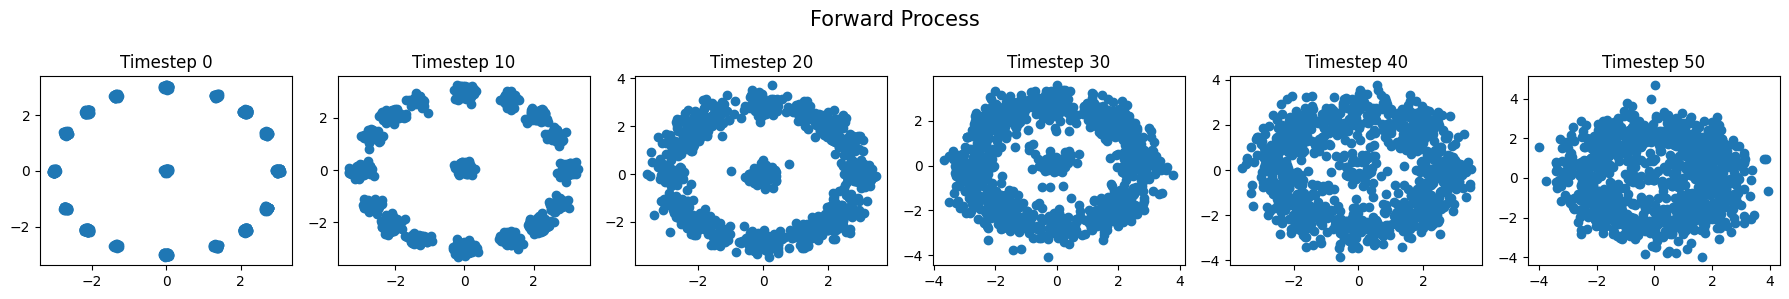

In [ ]:
plot_samples(forward_samples,title = "Forward Process")

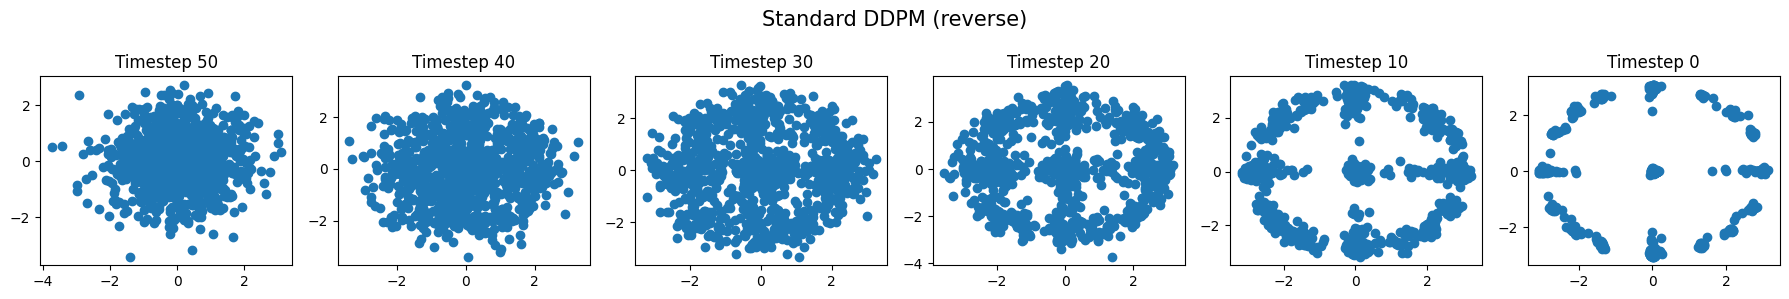

In [ ]:
plot_samples(reverse_samples[:],reverse= True,title = "Standard DDPM (reverse)")

## Koopman

### Input space latent (Koopman IS diffusion)

In [ ]:
def koopman_IS_propagate(model,x_t,t_val,k=1):
  n_points = x_t.shape[0]
  t = torch.from_numpy(np.repeat(t_val, n_points)).long().to(device)


  x_t_plus_k = model(x_t,t)
  return x_t_plus_k

## Compare standard and Koopman IS diffusion (without additional loss term)

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

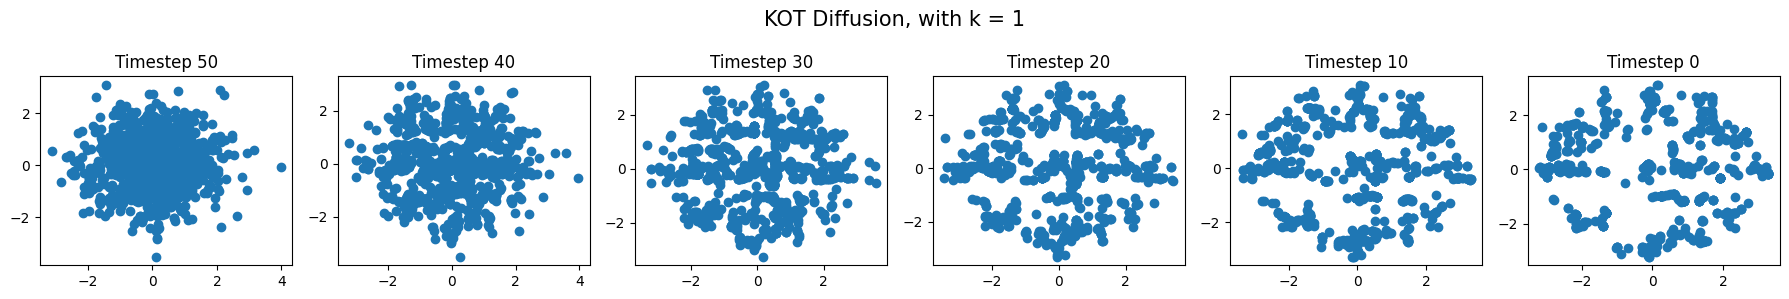

  0%|          | 0/26 [00:00<?, ?it/s]

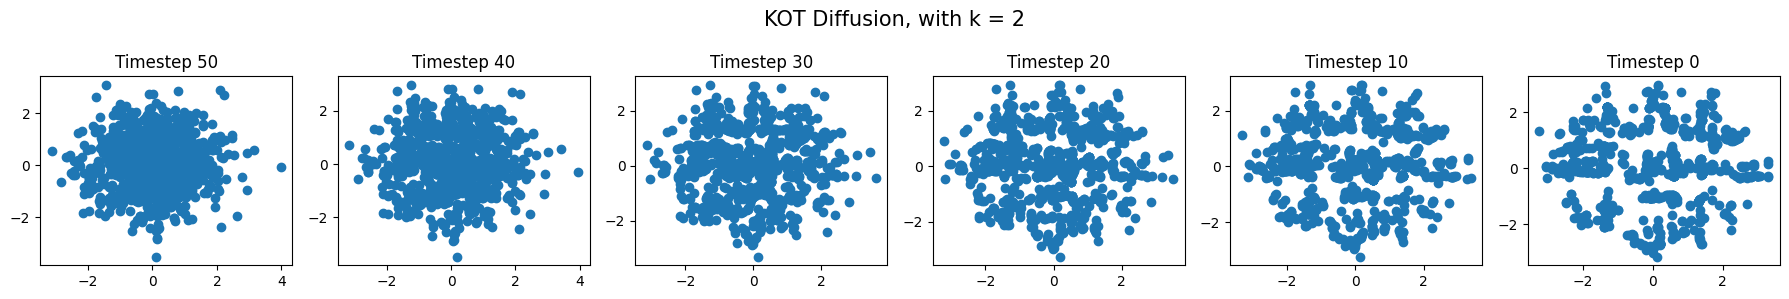

  0%|          | 0/18 [00:00<?, ?it/s]

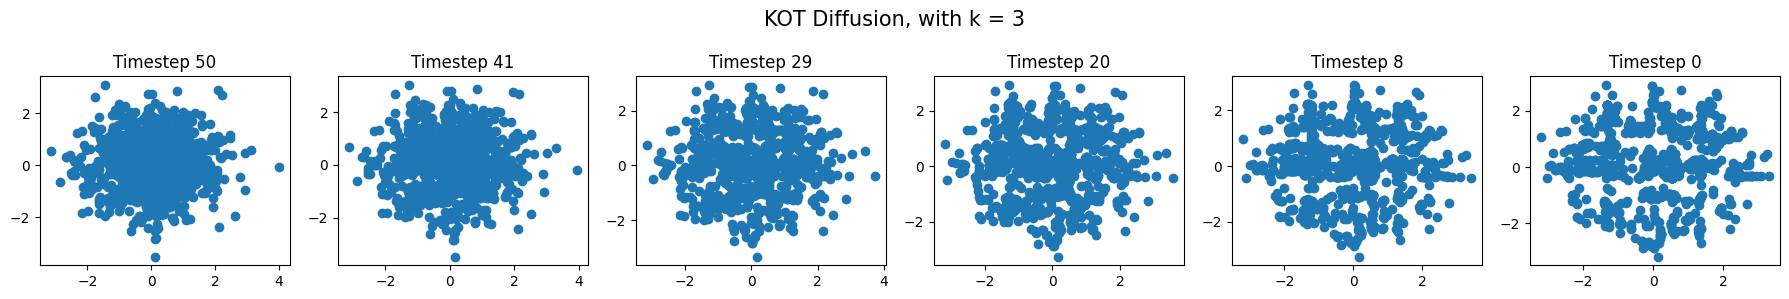

  0%|          | 0/14 [00:00<?, ?it/s]

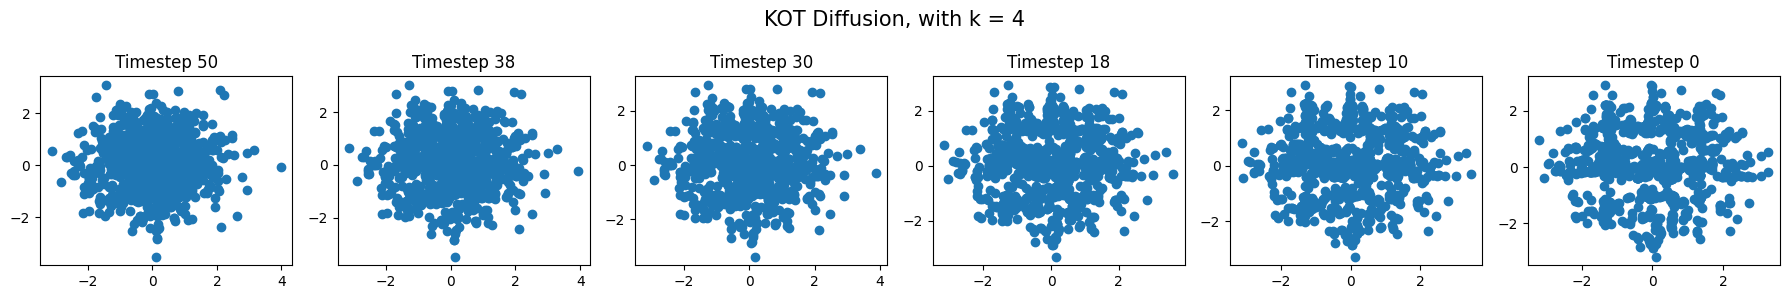

  0%|          | 0/11 [00:00<?, ?it/s]

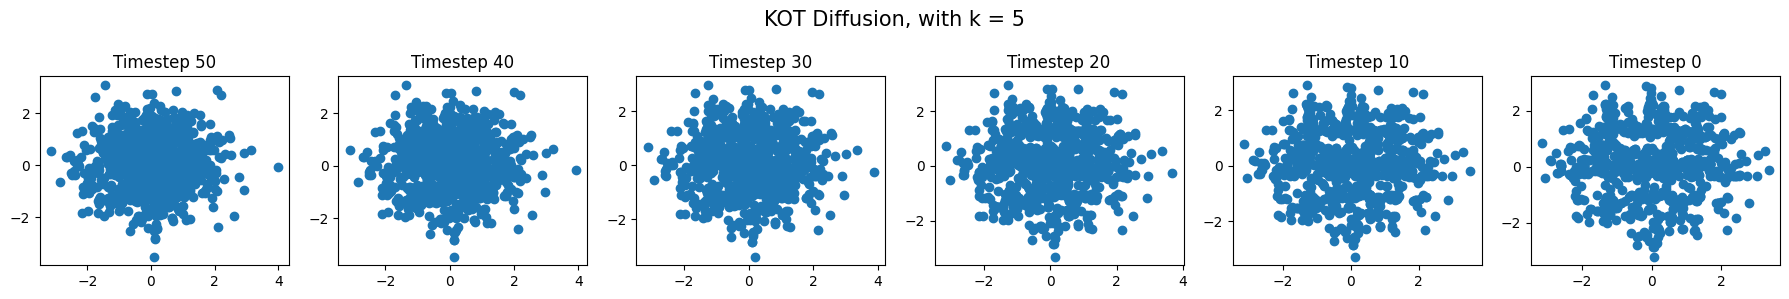

In [ ]:
num_timesteps = 50
eval_batch_size = 1000

sample_og = torch.randn(eval_batch_size, 2).to(device)






sample = sample_og.detach().clone()
timesteps = list(range(num_timesteps))[::-1]
reverse_samples = []
reverse_samples.append(sample.cpu().numpy())


##Normal Reverse Process
for i, t in enumerate(tqdm(timesteps)):
    t = torch.from_numpy(np.repeat(t, eval_batch_size)).long().to(device)
    with torch.no_grad():
        residual = model(sample, t)
        # pdb.set_trace()
    # sample = noise_scheduler.step(residual, t[0], sample) #standard diffusion
    sample = residual #input space diffusion


    reverse_samples.append(sample.cpu().numpy())

# reverse_samples = reverse_samples[:-1]
# pdb.set_trace()
# timesteps = timesteps[1:]


######
k = 4
# koopman_sample = sample_og.detach().clone() #init here to see phenomenon of better convergence with extra koopman steps


for k in range(1,6,1):
  koopman_sample = sample_og.detach().clone()  #init here for correct init, i.e Normal distribution to start
  koopman_timesteps = list(range(0,num_timesteps,k))
  if 50 not in koopman_timesteps:
    koopman_timesteps.append(50)
  koopman_timesteps = koopman_timesteps[::-1]

  koopman_reverse_samples = []
  koopman_reverse_samples.append(koopman_sample.detach().cpu().numpy())


  for i, t in enumerate(tqdm(koopman_timesteps)):
    koopman_sample = koopman_IS_propagate(model,koopman_sample,t,k = k)
    koopman_reverse_samples.append(koopman_sample.detach().cpu().numpy())

  adjusted_reverse_samples = [reverse_samples[t] for t in timesteps if t in koopman_timesteps][::-1]


  # print(koopman_timesteps)
  # plot_samples(adjusted_reverse_samples,reverse=True,indices = koopman_timesteps[::-1],title = "KOT Diffusion, k=1")
  plot_samples(koopman_reverse_samples,reverse=True,indices = koopman_timesteps[::-1], title = f"KOT Diffusion, with k = {k}")

## Compare standard and Koopman IS diffusion (with additional loss term)

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

[49, 48, 47, 46, 45, 44, 43, 42, 41, 40, 39, 38, 37, 36, 35, 34, 33, 32, 31, 30, 29, 28, 27, 26, 25, 24, 23, 22, 21, 20, 19, 18, 17, 16, 15, 14, 13, 12, 11, 10, 9, 8, 7, 6, 5, 4, 3, 2, 1, 0]


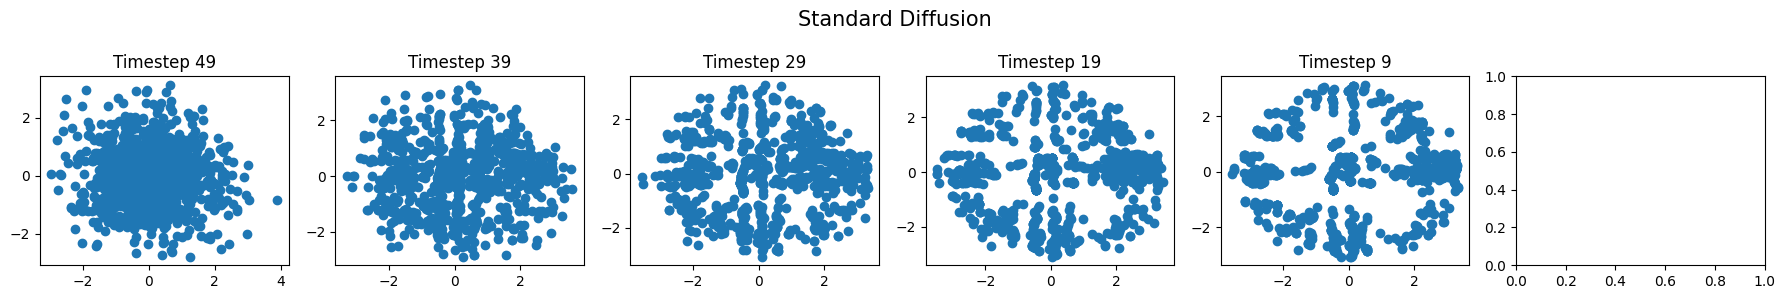

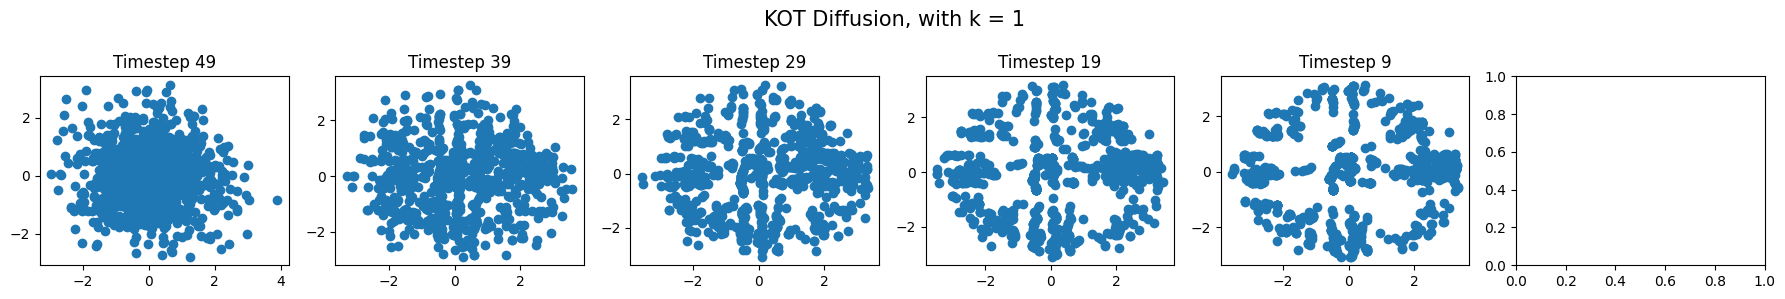

  0%|          | 0/25 [00:00<?, ?it/s]

[48, 46, 44, 42, 40, 38, 36, 34, 32, 30, 28, 26, 24, 22, 20, 18, 16, 14, 12, 10, 8, 6, 4, 2, 0]


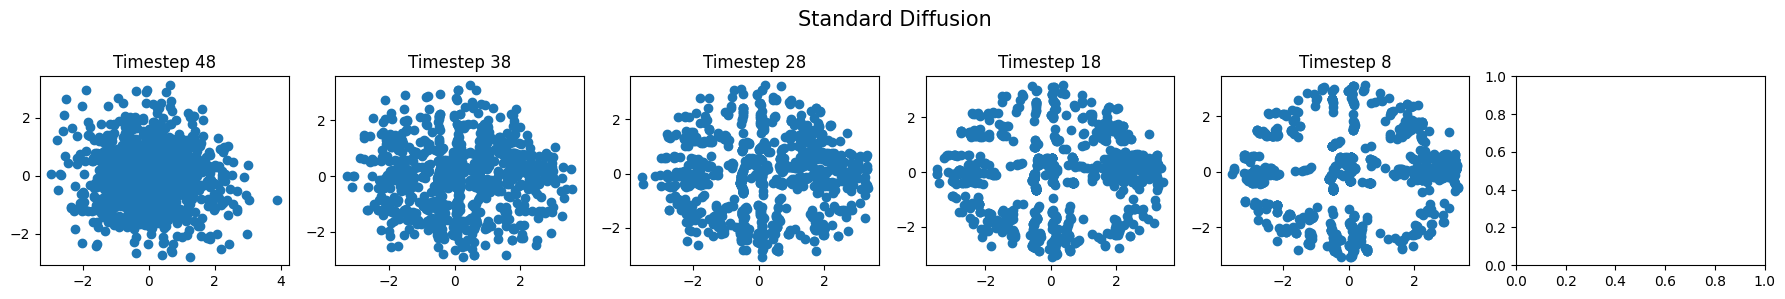

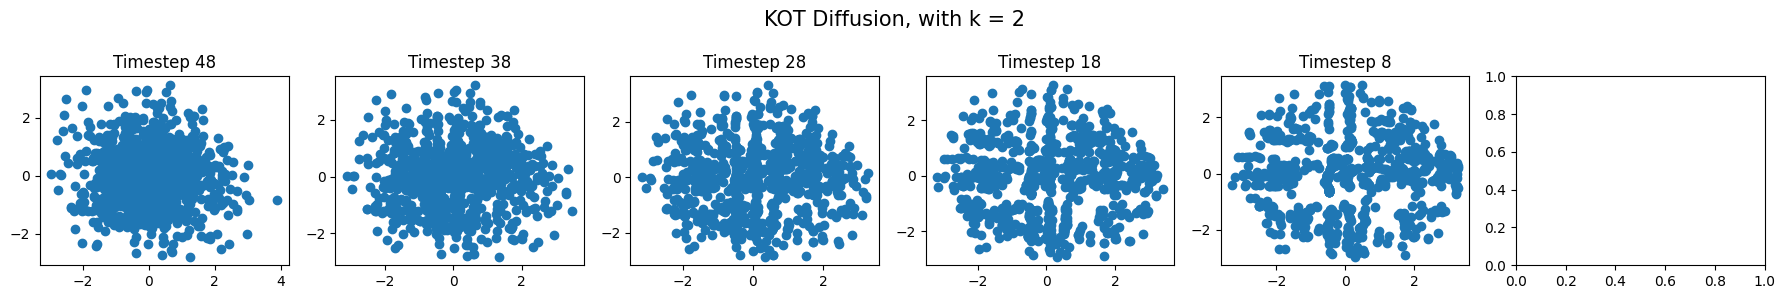

In [ ]:
num_timesteps = 50
eval_batch_size = 1000

sample_og = torch.randn(eval_batch_size, 2).to(device)






sample = sample_og.detach().clone()
timesteps = list(range(num_timesteps))[::-1]
reverse_samples = []
reverse_samples.append(sample.cpu().numpy())


##Normal Reverse Process
for i, t in enumerate(tqdm(timesteps)):
    t = torch.from_numpy(np.repeat(t, eval_batch_size)).long().to(device)
    with torch.no_grad():
        residual = model(sample, t)
    # sample = noise_scheduler.step(residual, t[0], sample) #standard diffusion
    sample = residual #input space diffusion


    reverse_samples.append(sample.cpu().numpy())



######
# koopman_sample = sample_og.detach().clone() #init here to see phenomenon of better convergence with extra koopman steps


for k in range(1,3,1):
  koopman_sample = sample_og.detach().clone()  #init here for correct init, i.e Normal distribution to start
  koopman_timesteps = list(range(0,num_timesteps,k))[::-1]
  koopman_reverse_samples = []
  koopman_reverse_samples.append(koopman_sample.detach().cpu().numpy())


  for i, t in enumerate(tqdm(koopman_timesteps)):
    koopman_sample = koopman_IS_propagate(model,koopman_sample,t,k = k)
    koopman_reverse_samples.append(koopman_sample.detach().cpu().numpy())

  adjusted_reverse_samples = [reverse_samples[t] for t in timesteps if t in koopman_timesteps][::-1]


  print(koopman_timesteps)
  plot_samples(adjusted_reverse_samples,reverse=True,indices = koopman_timesteps,title = "Standard Diffusion")
  plot_samples(koopman_reverse_samples,reverse=True,indices = koopman_timesteps, title = f"KOT Diffusion, with k = {k}")

## Extra Propagation experiment

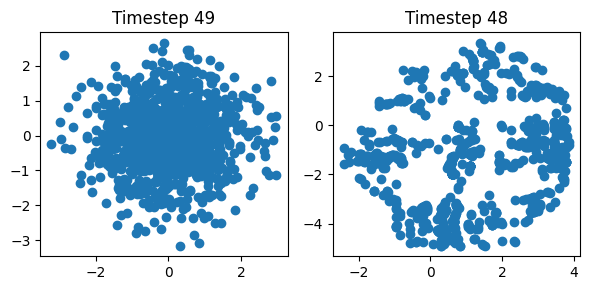

In [ ]:
num_timesteps = 50
eval_batch_size = 1000

sample_og = torch.randn(eval_batch_size, 2).to(device)


k = 2
koopman_sample = sample_og.detach().clone()  #init here for correct init, i.e Normal distribution to start
# koopman_timesteps = list(range(0,num_timesteps,k))[::-1]
# koopman_reverse_samples = []
# koopman_reverse_samples.append(koopman_sample.detach().cpu().numpy())


for t in range(0,65,k):
  koopman_sample = koopman_IS_propagate(model,koopman_sample,t,k = k)
  koopman_reverse_samples.append(koopman_sample.detach().cpu().numpy())



plot_samples([sample_og.cpu().detach().numpy(),koopman_sample.detach().cpu().numpy()],num_subplots = 2)
